# Cohort Revenue Retention Analysis with Flax and NumPyro

In this notebook we present an alternative implementation of the cohort-revenue-retention model presented in the blog post [Cohort Revenue & Retention Analysis: A Bayesian Approach](https://juanitorduz.github.io/revenue_retention/) where we show how to replace the [BART](https://github.com/pymc-devs/pymc-bart) retention component with a general neural network implemented with [Flax](https://github.com/google/flax). This allows faster inference, as we can use [NumPyro](https://github.com/pyro-ppl/numpyro)'s NUTS sampler or any of the stochastic variational inference (SVI) algorithms available. We could even use a wider family of samplers using the newly released package [`Bayeux`](https://jax-ml.github.io/bayeux/). 
We use the same simulated dataset to be able to compare the approaches. Overall, the retention and revenue in and out-of sample predictions, as well as the credible intervals are very similar to the ones obtained with the [BART](https://github.com/pymc-devs/pymc-bart) model.

**Remark:** On the other hand, we loose the PDP and ICE plots, which are useful to understand the influence of regressors on the target variable. We could of course trying implementing it by hand, but it would not be straightforward to make it fast, at least in my view (please let me know if you have any ideas on how to do it.)

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from flax import linen as nn
from jax import random
from numpyro.contrib.module import random_flax_module
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive
from scipy.special import logit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MaxAbsScaler,
    OneHotEncoder,
    StandardScaler,
)

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We start by reading the data from previous posts (see [here](https://github.com/juanitorduz/website_projects/blob/master/Python/retantion_data.py) for the code to generate the data).

In [3]:
data_df = pd.read_csv(
    "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/retention_data.csv",
    parse_dates=["cohort", "period"],
)

data_df.head()

cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      150 2020-01-01  1430           0          -1.807373   
1 2020-01-01      150 2020-02-01  1430          31          -1.474736   
2 2020-01-01      150 2020-03-01  1430          60          -2.281286   
3 2020-01-01      150 2020-04-01  1430          91          -3.206610   
4 2020-01-01      150 2020-05-01  1430         121          -3.112983   

   retention_true  n_active_users       revenue  retention  
0        0.140956             150  14019.256906   1.000000  
1        0.186224              25   1886.501237   0.166667  
2        0.092685              13   1098.136314   0.086667  
3        0.038918               6    477.852458   0.040000  
4        0.042575               2    214.667937   0.013333

## Data Preprocessing

We make a data train-test split as in the previous post.

In [4]:
period_train_test_split = "2022-11-01"

train_data_df = data_df.query("period <= @period_train_test_split")
test_data_df = data_df.query("period > @period_train_test_split")
test_data_df = test_data_df[
    test_data_df["cohort"].isin(train_data_df["cohort"].unique())
]

## EDA

For a detailed EDA of the data, please refer to the previous posts ([A Simple Cohort Retention Analysis in PyMC](https://juanitorduz.github.io/retention/),  [Cohort Retention Analysis with BART](https://juanitorduz.github.io/retention_bart/) and  [Cohort Revenue & Retention Analysis: A Bayesian Approach](https://juanitorduz.github.io/revenue_retention/)). We assume you are familiar with the dataset. 

Let's recall how the retention matrix looks like:

Text(0.5, 1.0, 'Retention by Cohort and Period')

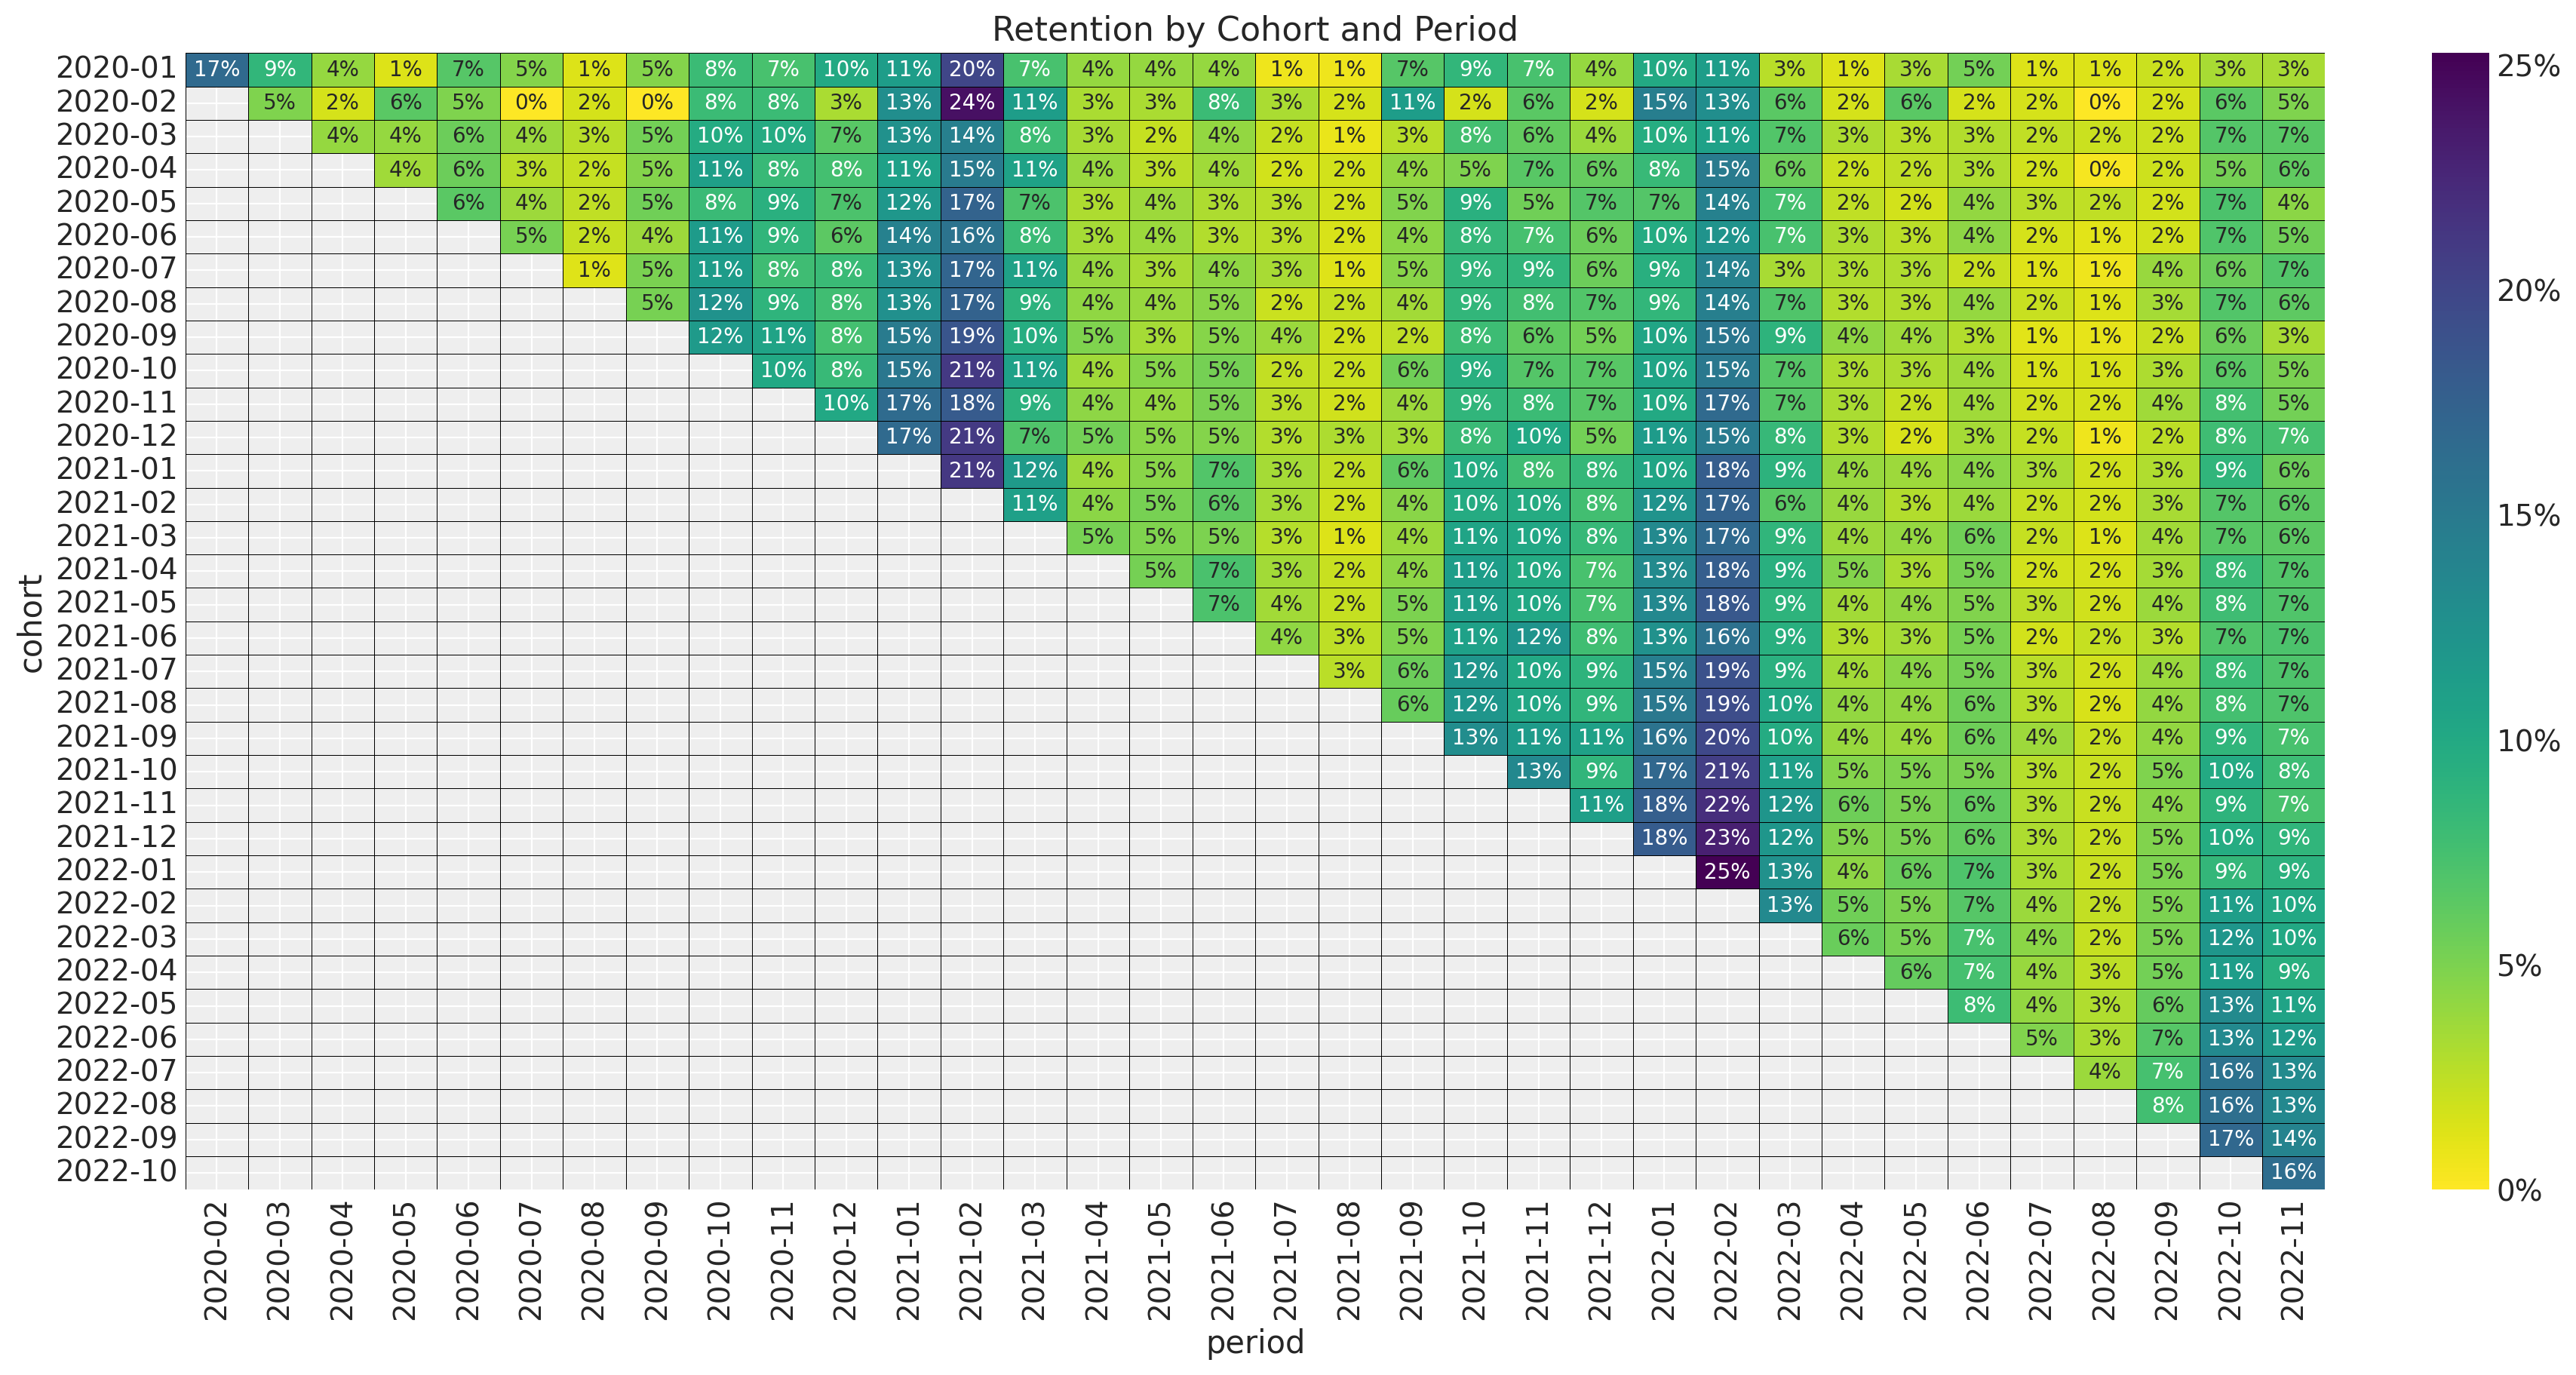

In [5]:
fig, ax = plt.subplots(figsize=(17, 9))

(
    train_data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot_table(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(func=lambda y, _: f"{y :0.0%}")},
        ax=ax,
    )
)

ax.set_title("Retention by Cohort and Period")

Similarly we can plot the revenue matrix:

Text(0.5, 1.0, 'Revenue by Cohort and Period')

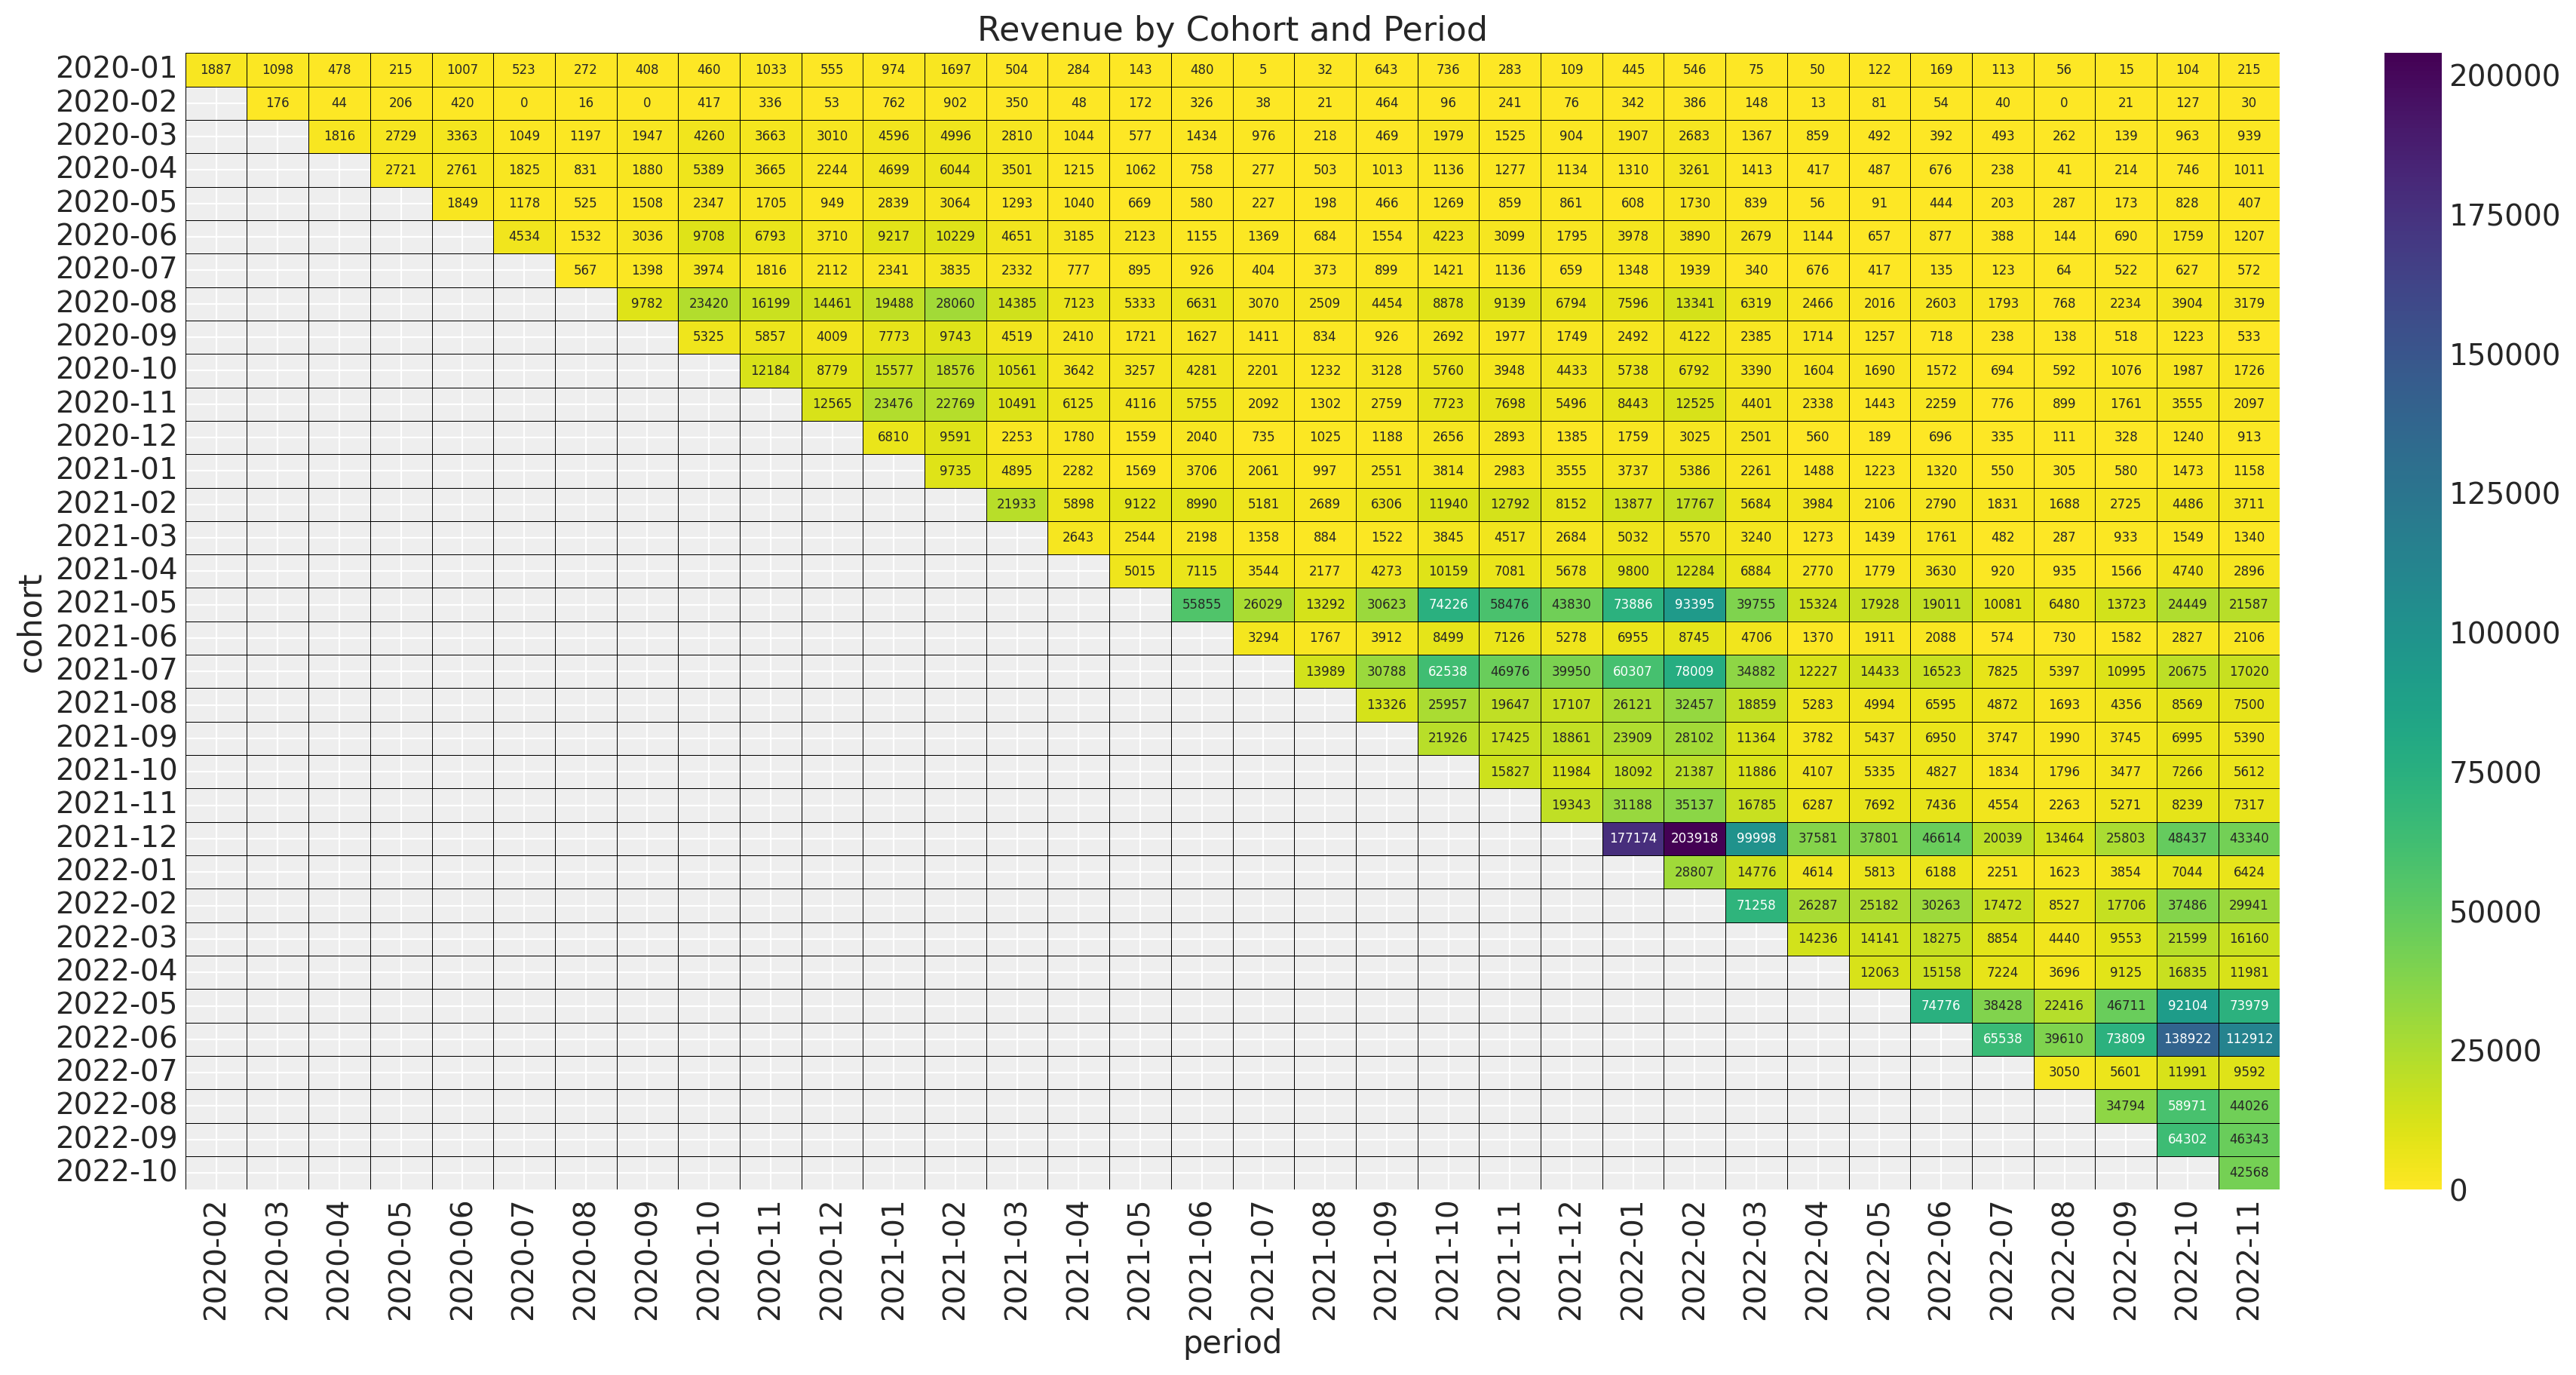

In [6]:
fig, ax = plt.subplots(figsize=(17, 9))


(
    train_data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "revenue"])
    .pivot_table(index="cohort", columns="period", values="revenue")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        annot_kws={"fontsize": 6},
        fmt="0.0f",
        cbar_kws={"format": mtick.FuncFormatter(lambda y, _: f"{y :0.0f}")},
        ax=ax,
    )
)

ax.set_title("Revenue by Cohort and Period")

Our objective is to model both components as the same time as we expect the revenue to depend on the retention levels.

## Model

Motivated by the analysis above we suggest the following retention-revenue model.

\begin{align*}
\text{Revenue} & \sim \text{Gamma}(N_{\text{active}}, \lambda) \\
\log(\lambda) = (& \text{intercept} \\
    & + \beta_{\text{cohort age}} \text{cohort age} \\
    & + \beta_{\text{age}} \text{age} \\
    & + \beta_{\text{cohort age} \times \text{age}} \text{cohort age} \times \text{age} ) \\
N_{\text{active}} & \sim \text{Binomial}(N_{\text{total}}, p) \\
\textrm{logit}(p) & = \text{NN}(\text{cohort age}, \text{age}, \text{month})
\end{align*}

where $\text{NN}$ is a neural network implemented with Flax. We use a simple architecture with one hidden layers with $4$ units each and sigmoid activation functions. For this simple case this architecture is enough. You can of course try more complex models.

The magic for this approach lies in the NumPyro module [`numpyro/contrib/module.py`](https://github.com/pyro-ppl/numpyro/blob/master/numpyro/contrib/module.py) where we have very useful functions to integrate Flax models with NumPyro. In particular, we will use the [`random_flax_module`](https://num.pyro.ai/en/stable/primitives.html#random-flax-module) which allow us to set priors on the layers weights and biases.

### Data Transformations

We do similar transformations as in the previous posts.

In [7]:
eps = np.finfo(float).eps
train_data_red_df = train_data_df.query("cohort_age > 0").reset_index(drop=True)
train_obs_idx = train_data_red_df.index.to_numpy()
train_n_users = train_data_red_df["n_users"].to_numpy()
train_n_active_users = train_data_red_df["n_active_users"].to_numpy()
train_retention = train_data_red_df["retention"].to_numpy()
train_retention_logit = logit(train_retention + eps)
train_data_red_df["month"] = train_data_red_df["period"].dt.strftime("%m").astype(int)
train_data_red_df["cohort_month"] = (
    train_data_red_df["cohort"].dt.strftime("%m").astype(int)
)
train_data_red_df["period_month"] = (
    train_data_red_df["period"].dt.strftime("%m").astype(int)
)
train_revenue = train_data_red_df["revenue"].to_numpy() + eps
train_revenue_per_user = train_revenue / (train_n_active_users + eps)

train_cohort = train_data_red_df["cohort"].to_numpy()
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period = train_data_red_df["period"].to_numpy()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()

features: list[str] = ["age", "cohort_age", "month"]
x_train = train_data_red_df[features]

train_age = train_data_red_df["age"].to_numpy()
train_age_scaler = MaxAbsScaler()
train_age_scaled = train_age_scaler.fit_transform(train_age.reshape(-1, 1)).flatten()
train_cohort_age = train_data_red_df["cohort_age"].to_numpy()
train_cohort_age_scaler = MaxAbsScaler()
train_cohort_age_scaled = train_cohort_age_scaler.fit_transform(
    train_cohort_age.reshape(-1, 1)
).flatten()

For the variables entering into the model we need to convert them to `jnp.array` objects.

In [8]:
train_n_users = jnp.array(train_n_users)
train_n_active_users = jnp.array(train_n_active_users)
train_revenue = jnp.array(train_revenue)

Moreover, for the design matrix feeding the neural network we also need to scale the features (Note this was not necessary with the BART model). We also one-hot-encode the `month` variable.

In [9]:
numerical_features = ["age", "cohort_age"]
categorical_features = ["month"]

numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_features_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(drop="first", sparse_output=False))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_features_transformer, categorical_features),
    ]
).set_output(transform="pandas")

preprocessor.fit(x_train)
x_train_preprocessed = preprocessor.transform(x_train)

x_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num__age         595 non-null    float64
 1   num__cohort_age  595 non-null    float64
 2   cat__month_2     595 non-null    float64
 3   cat__month_3     595 non-null    float64
 4   cat__month_4     595 non-null    float64
 5   cat__month_5     595 non-null    float64
 6   cat__month_6     595 non-null    float64
 7   cat__month_7     595 non-null    float64
 8   cat__month_8     595 non-null    float64
 9   cat__month_9     595 non-null    float64
 10  cat__month_10    595 non-null    float64
 11  cat__month_11    595 non-null    float64
 12  cat__month_12    595 non-null    float64
dtypes: float64(13)
memory usage: 60.6 KB


Finally, we convert the transformed design matrix to a `jnp.array` object.

In [10]:
x_train_preprocessed_array = jnp.array(x_train_preprocessed)

## Model Specification

We are now ready to write the model. First we define the neural network architecture in Flax.

In [11]:
class RetentionMLP(nn.Module):
    layers: list[int]

    @nn.compact
    def __call__(self, x):
        for num_features in self.layers:
            x = nn.sigmoid(nn.Dense(features=num_features)(x))
        return x

Now we write the NumPyro model. For the weights and biases we use set Normal priors centered around zero with unit variance.

In [12]:
def model(x, age, cohort_age, n_users, revenue=None, n_active_users=None):
    eps = np.finfo(float).eps

    retention_nn = random_flax_module(
        "retention_nn",
        RetentionMLP(layers=[4, 1]),
        prior=dist.Laplace(loc=0, scale=1),
        input_shape=(x.shape[1],),
    )
    retention = numpyro.deterministic("retention", retention_nn(x).squeeze(-1))

    intercept = numpyro.sample("intercept", dist.Normal(loc=0, scale=1))
    b_age = numpyro.sample("b_age", dist.Normal(loc=0, scale=1))
    b_cohort_age = numpyro.sample("b_cohort_age", dist.Normal(loc=0, scale=1))
    b_interaction = numpyro.sample("b_interaction", dist.Normal(loc=0, scale=1))

    lam_log = numpyro.deterministic(
        "lam_log",
        intercept
        + b_age * age
        + b_cohort_age * cohort_age
        + b_interaction * age * cohort_age,
    )

    lam = numpyro.deterministic("lam", jnp.exp(lam_log))

    with numpyro.plate("data", len(x)):
        n_active_users_estimated = numpyro.sample(
            "n_active_users_estimated",
            dist.Binomial(total_count=n_users, probs=retention),
            obs=n_active_users,
        )

        numpyro.deterministic("retention_estimated", n_active_users_estimated / n_users)

        numpyro.sample(
            "revenue_estimated",
            dist.Gamma(concentration=n_active_users_estimated + eps, rate=lam),
            obs=revenue,
        )

We can visualize the model using structure.

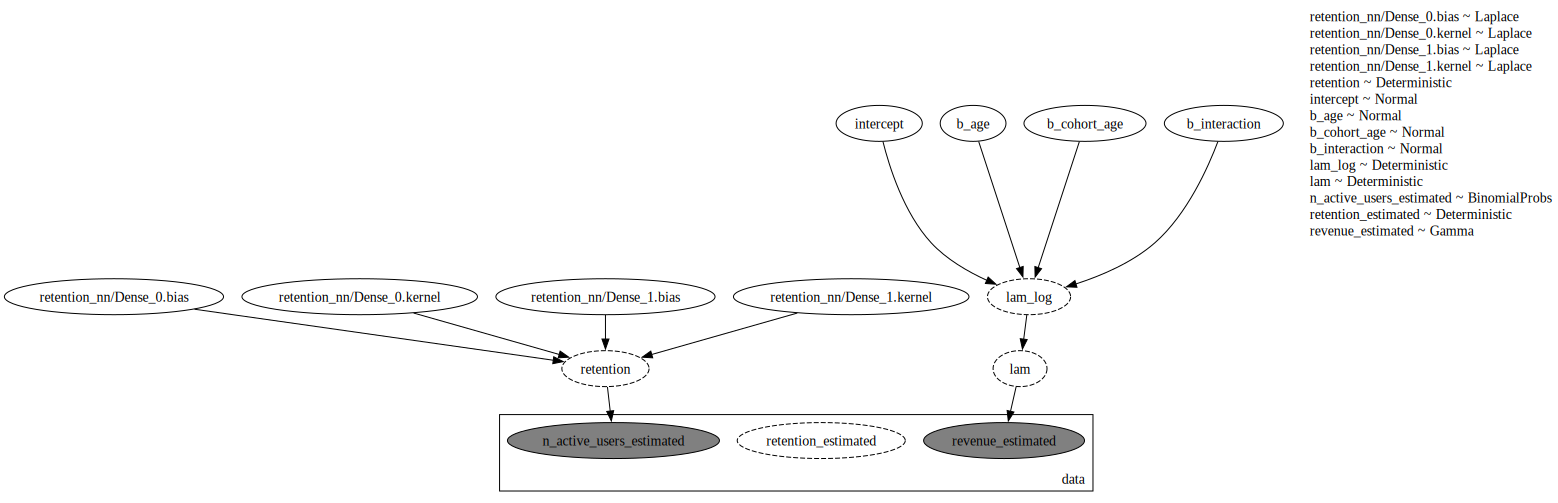

In [13]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "x": x_train_preprocessed_array,
        "age": train_age_scaled,
        "cohort_age": train_cohort_age_scaled,
        "n_users": train_n_users,
        "revenue": train_revenue,
        "n_active_users": train_n_active_users,
    },
    render_distributions=True,
    render_params=True,
)

## Inference: SVI

We use stochastic variational inference (SVI) to fit the model. We also se a [`AutoNormal`](https://num.pyro.ai/en/stable/autoguide.html#numpyro.infer.autoguide.AutoNormal) guide as a variational distribution.

100%|██████████| 15000/15000 [00:08<00:00, 1839.39it/s, init loss: 12061713.0000, avg. loss [14251-15000]: 6566.3535]


Text(0.5, 1.0, 'ELBO loss')

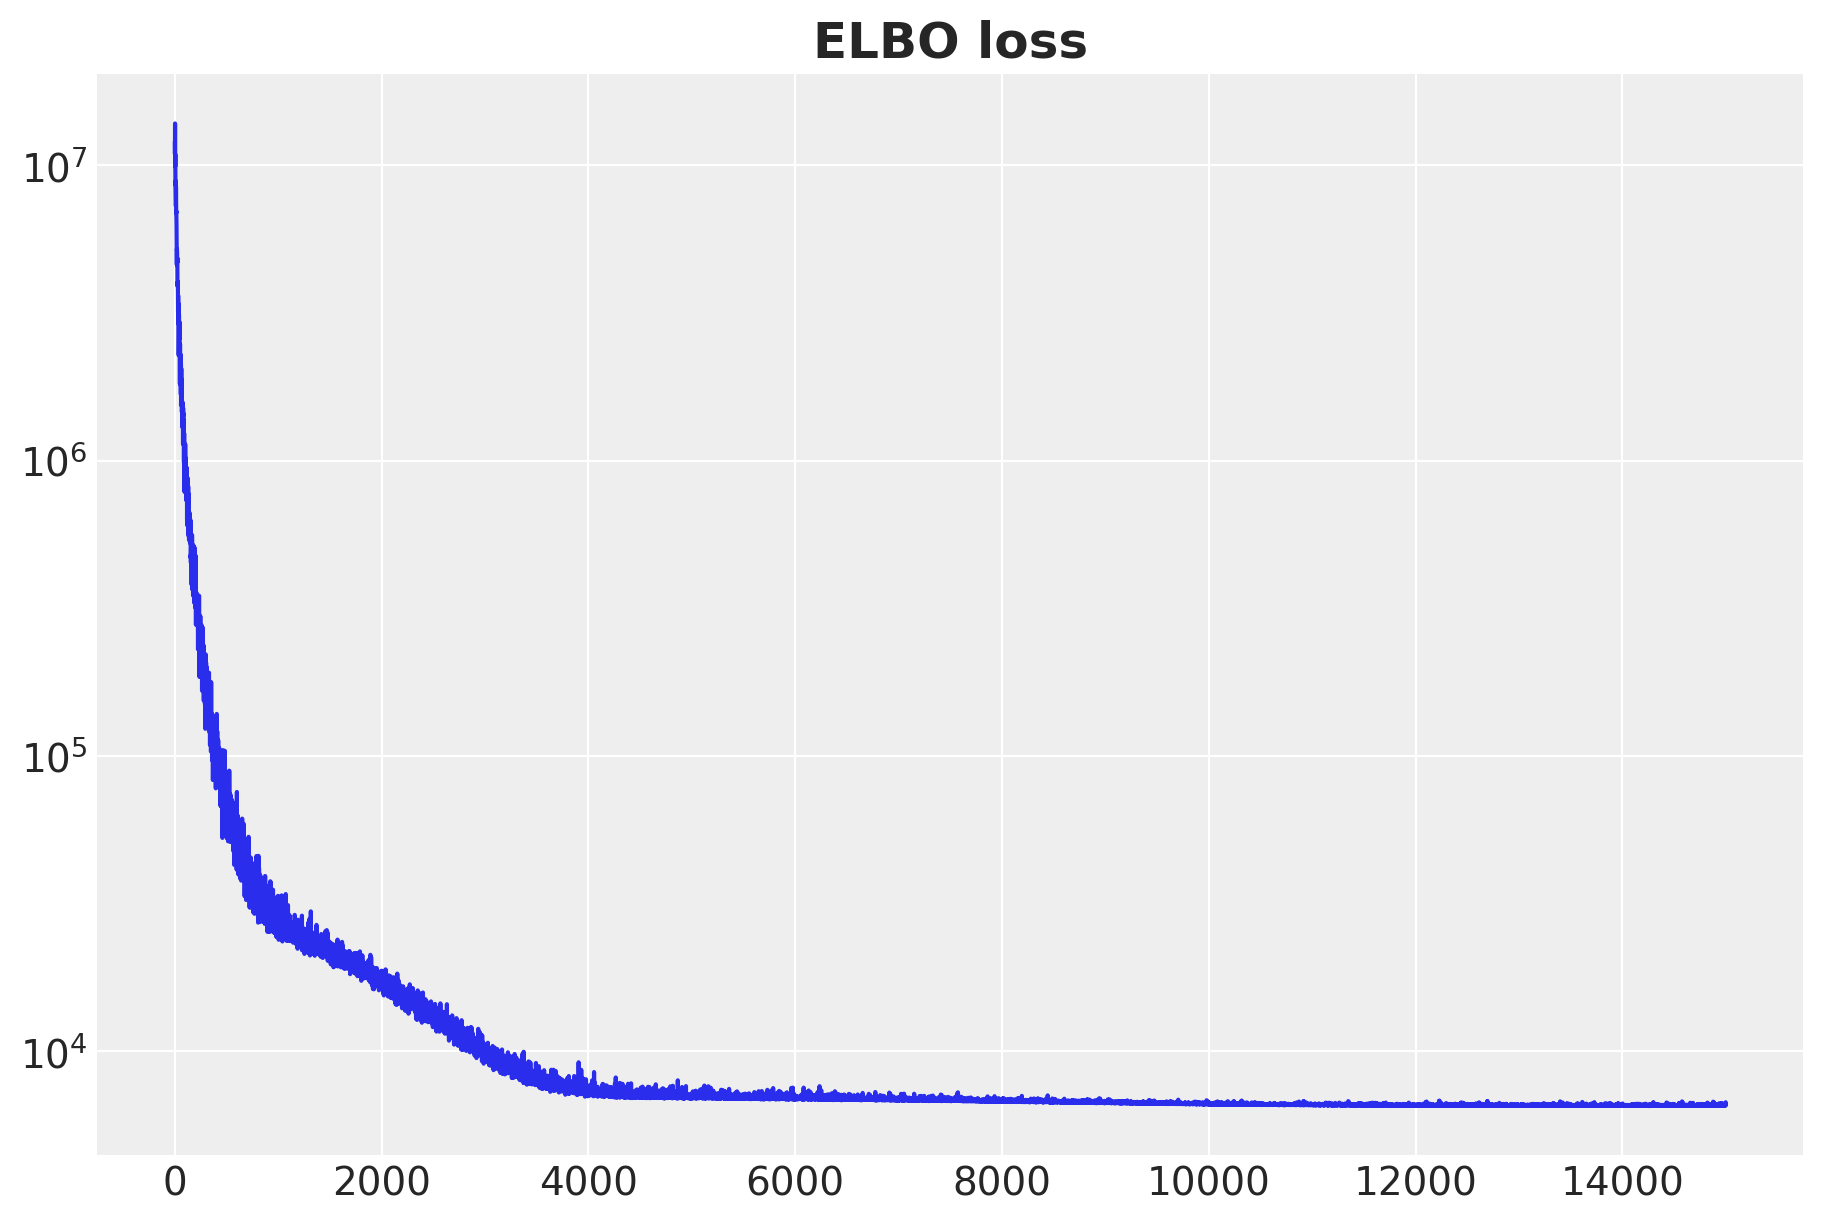

In [14]:
guide = AutoNormal(model=model)
optimizer = numpyro.optim.Adam(step_size=0.02)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
n_samples = 15_000
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    n_samples,
    x_train_preprocessed_array,
    train_age_scaled,
    train_cohort_age_scaled,
    train_n_users,
    train_revenue,
    train_n_active_users,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set_title("ELBO loss", fontsize=18, fontweight="bold")

We see a nicely decaying [ELBO](https://en.wikipedia.org/wiki/Evidence_lower_bound) curve.

Next we sample from the posterior distribution.

In [15]:
params = svi_result.params

posterior_predictive = Predictive(
    model=model, guide=guide, params=params, num_samples=4 * 2_000
)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey,
    x_train_preprocessed_array,
    train_age_scaled,
    train_cohort_age_scaled,
    train_n_users,
)

We structure the samples as an [`az.InferenceData`](https://python.arviz.org/en/stable/api/generated/arviz.InferenceData.html) object.

In [16]:
idata_svi = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples.items()
    },
    coords={"obs_idx": train_obs_idx},
    dims={
        "retention": ["obs_idx"],
        "n_active_users_estimated": ["obs_idx"],
        "retention_estimated": ["obs_idx"],
        "revenue_estimated": ["obs_idx"],
    },
)

## In-Sample Predictions

We now look at the in-sample fit. First we start with retention:

Text(0.5, 1.0, 'True vs Predicted Retention (Train)')

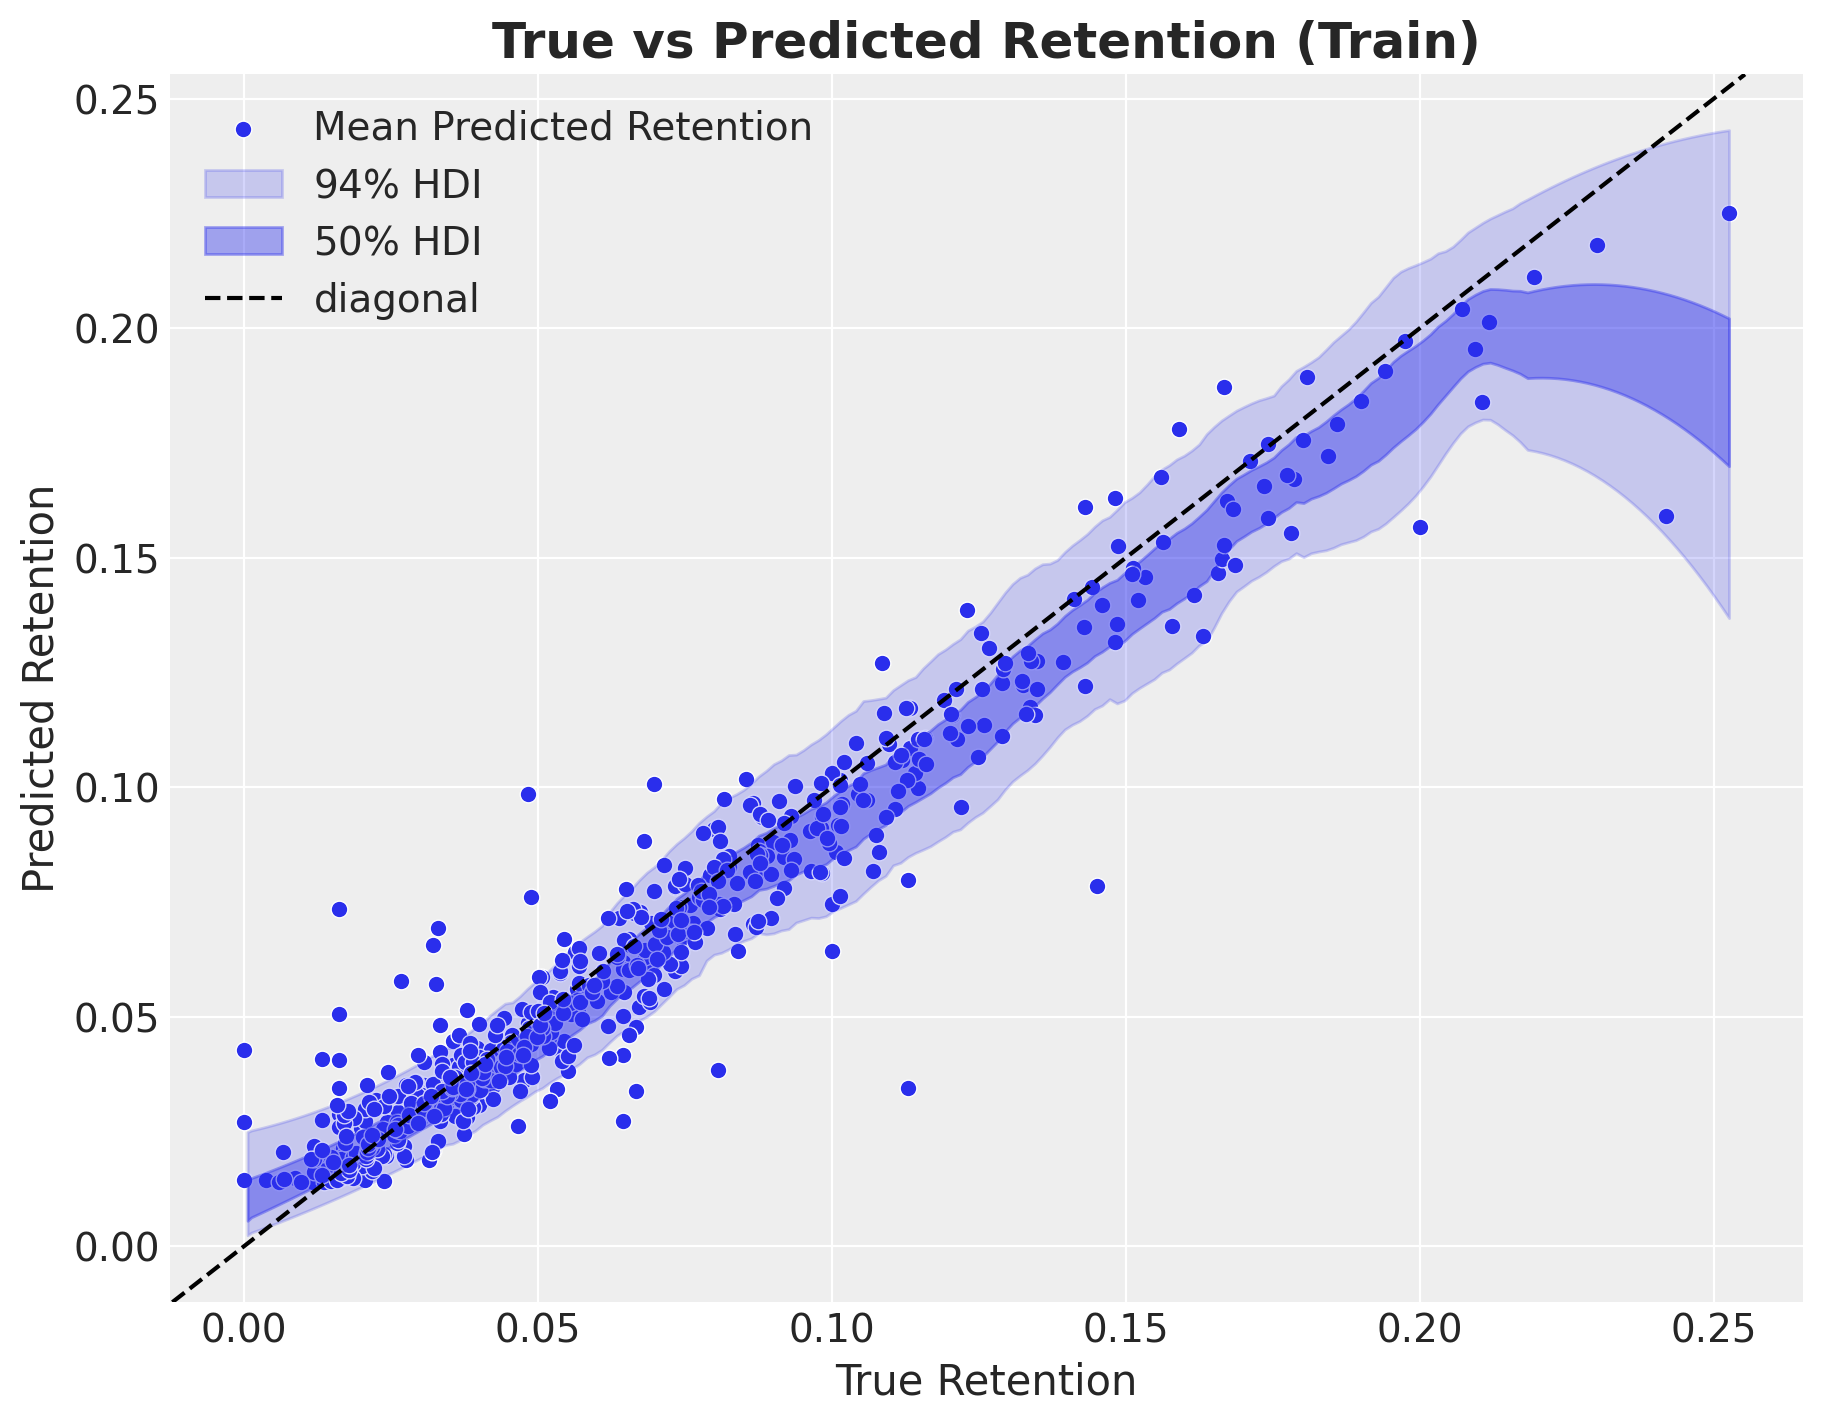

In [17]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(
    x=train_retention,
    y=idata_svi["posterior_predictive"]["retention_estimated"].mean(
        dim=["chain", "draw"]
    ),
    color="C0",
    label="Mean Predicted Retention",
    ax=ax,
)
az.plot_hdi(
    x=train_retention,
    y=idata_svi["posterior_predictive"]["retention_estimated"],
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=train_retention,
    y=idata_svi["posterior_predictive"]["retention_estimated"],
    hdi_prob=0.5,
    color="C0",
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI"},
    ax=ax,
)
ax.axline((0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend(loc="upper left")
ax.set(xlabel="True Retention", ylabel="Predicted Retention")
ax.set_title(
    label="True vs Predicted Retention (Train)", fontsize=18, fontweight="bold"
)

Overall it looks very reasonable. There are some point the model does not properly catch, but the previous BART model had the same issue.

The revenue in-sample predictions are also very similar to the ones obtained with the BART model.

Text(0.5, 1.0, 'True vs Predicted Revenue (Train)')

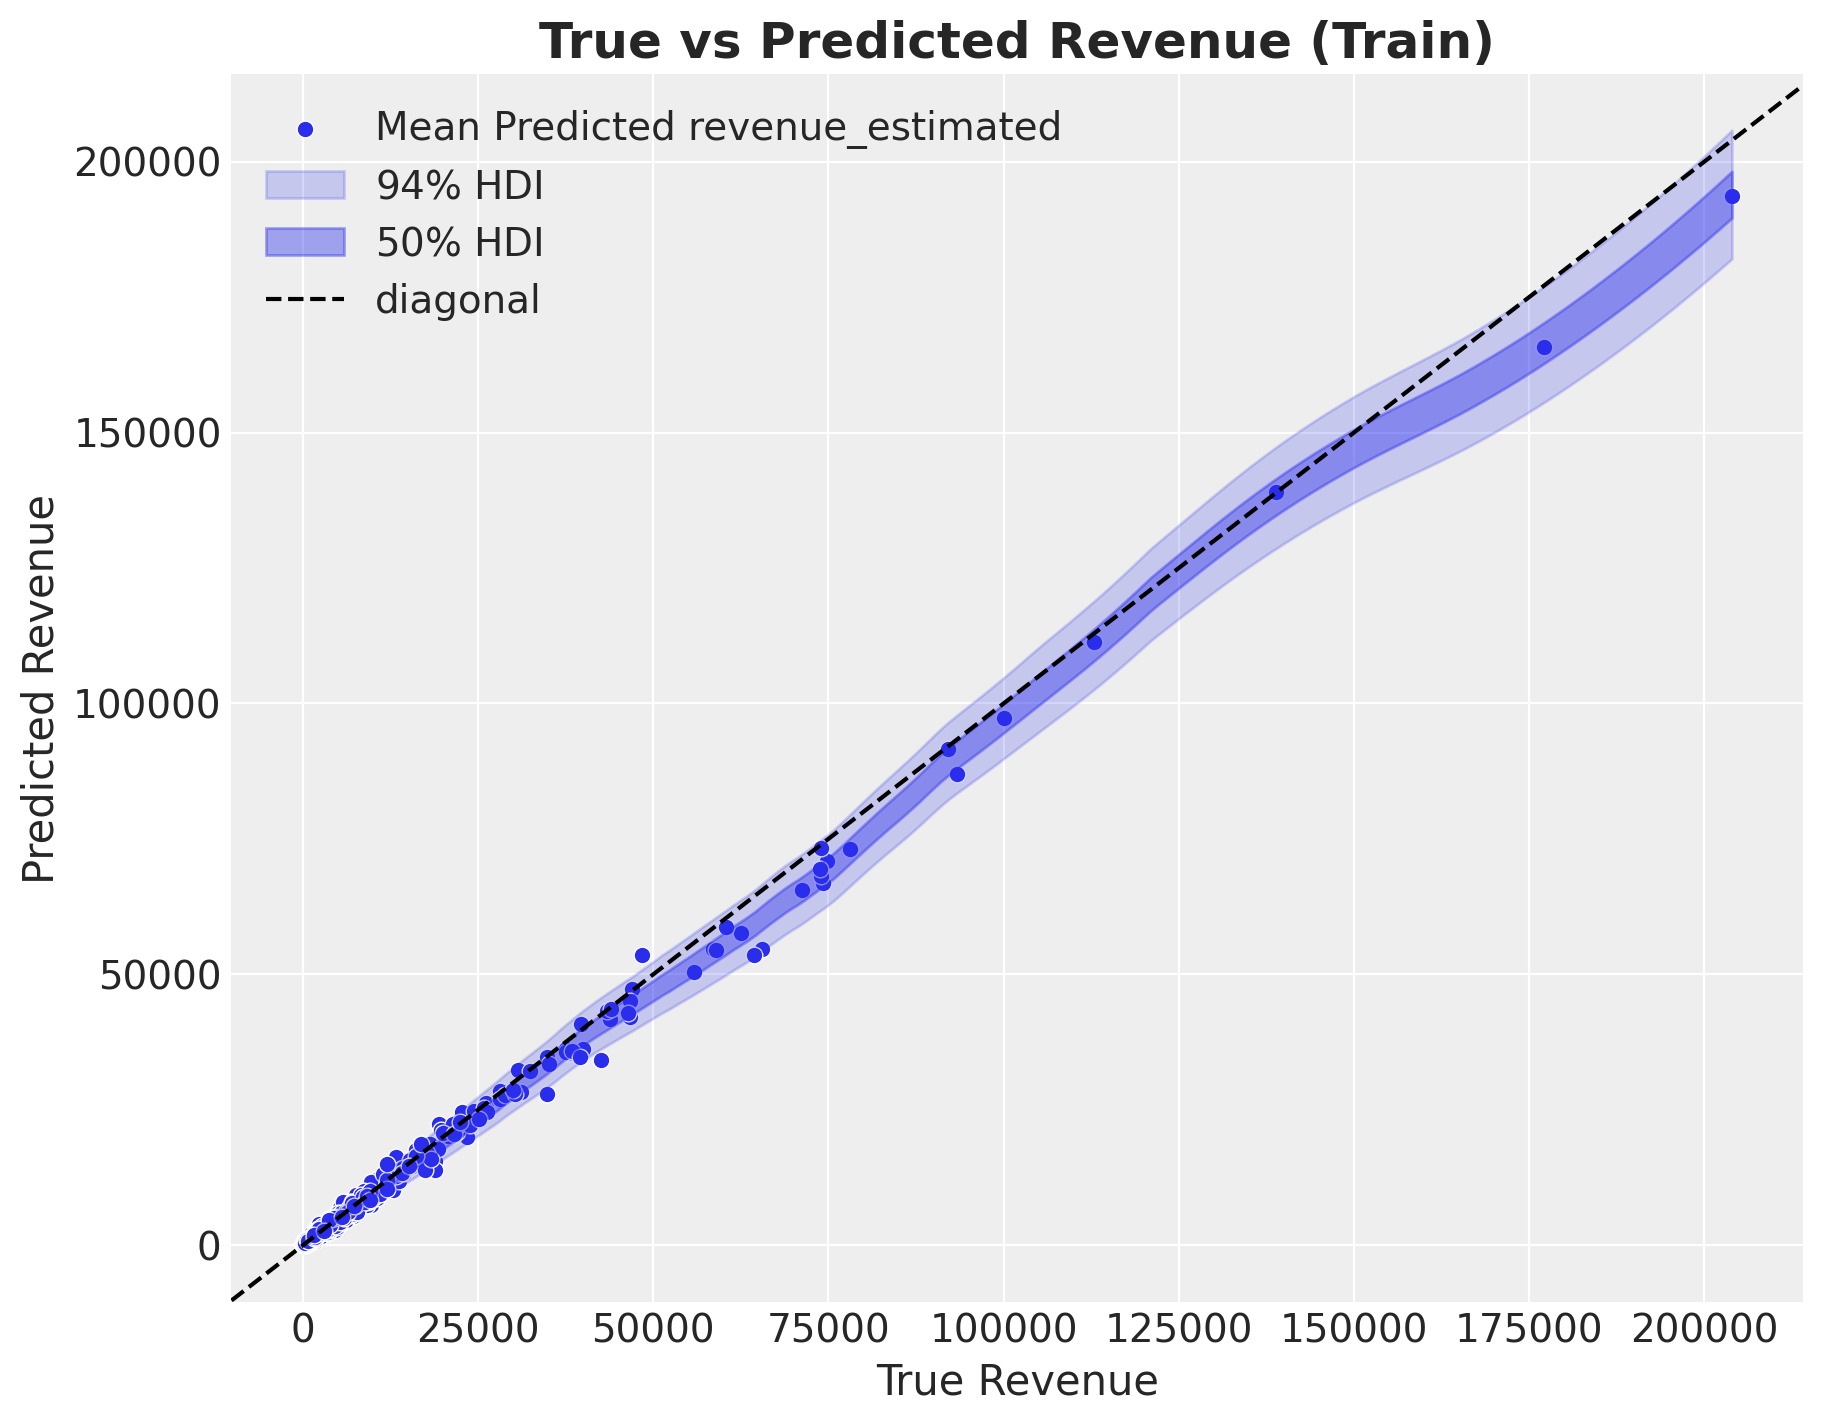

In [18]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(
    x=train_revenue,
    y=idata_svi["posterior_predictive"]["revenue_estimated"].mean(
        dim=["chain", "draw"]
    ),
    color="C0",
    label="Mean Predicted revenue_estimated",
    ax=ax,
)
az.plot_hdi(
    x=train_revenue,
    y=idata_svi["posterior_predictive"]["revenue_estimated"],
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=train_revenue,
    y=idata_svi["posterior_predictive"]["revenue_estimated"],
    hdi_prob=0.5,
    color="C0",
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI"},
    ax=ax,
)
ax.axline((0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend(loc="upper left")
ax.set(xlabel="True Revenue", ylabel="Predicted Revenue")
ax.set_title(label="True vs Predicted Revenue (Train)", fontsize=18, fontweight="bold")

As in the previous post, we select a couple of example cohorts to visualize the predictions:

- Retention

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_51400/3437728315.py:58: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


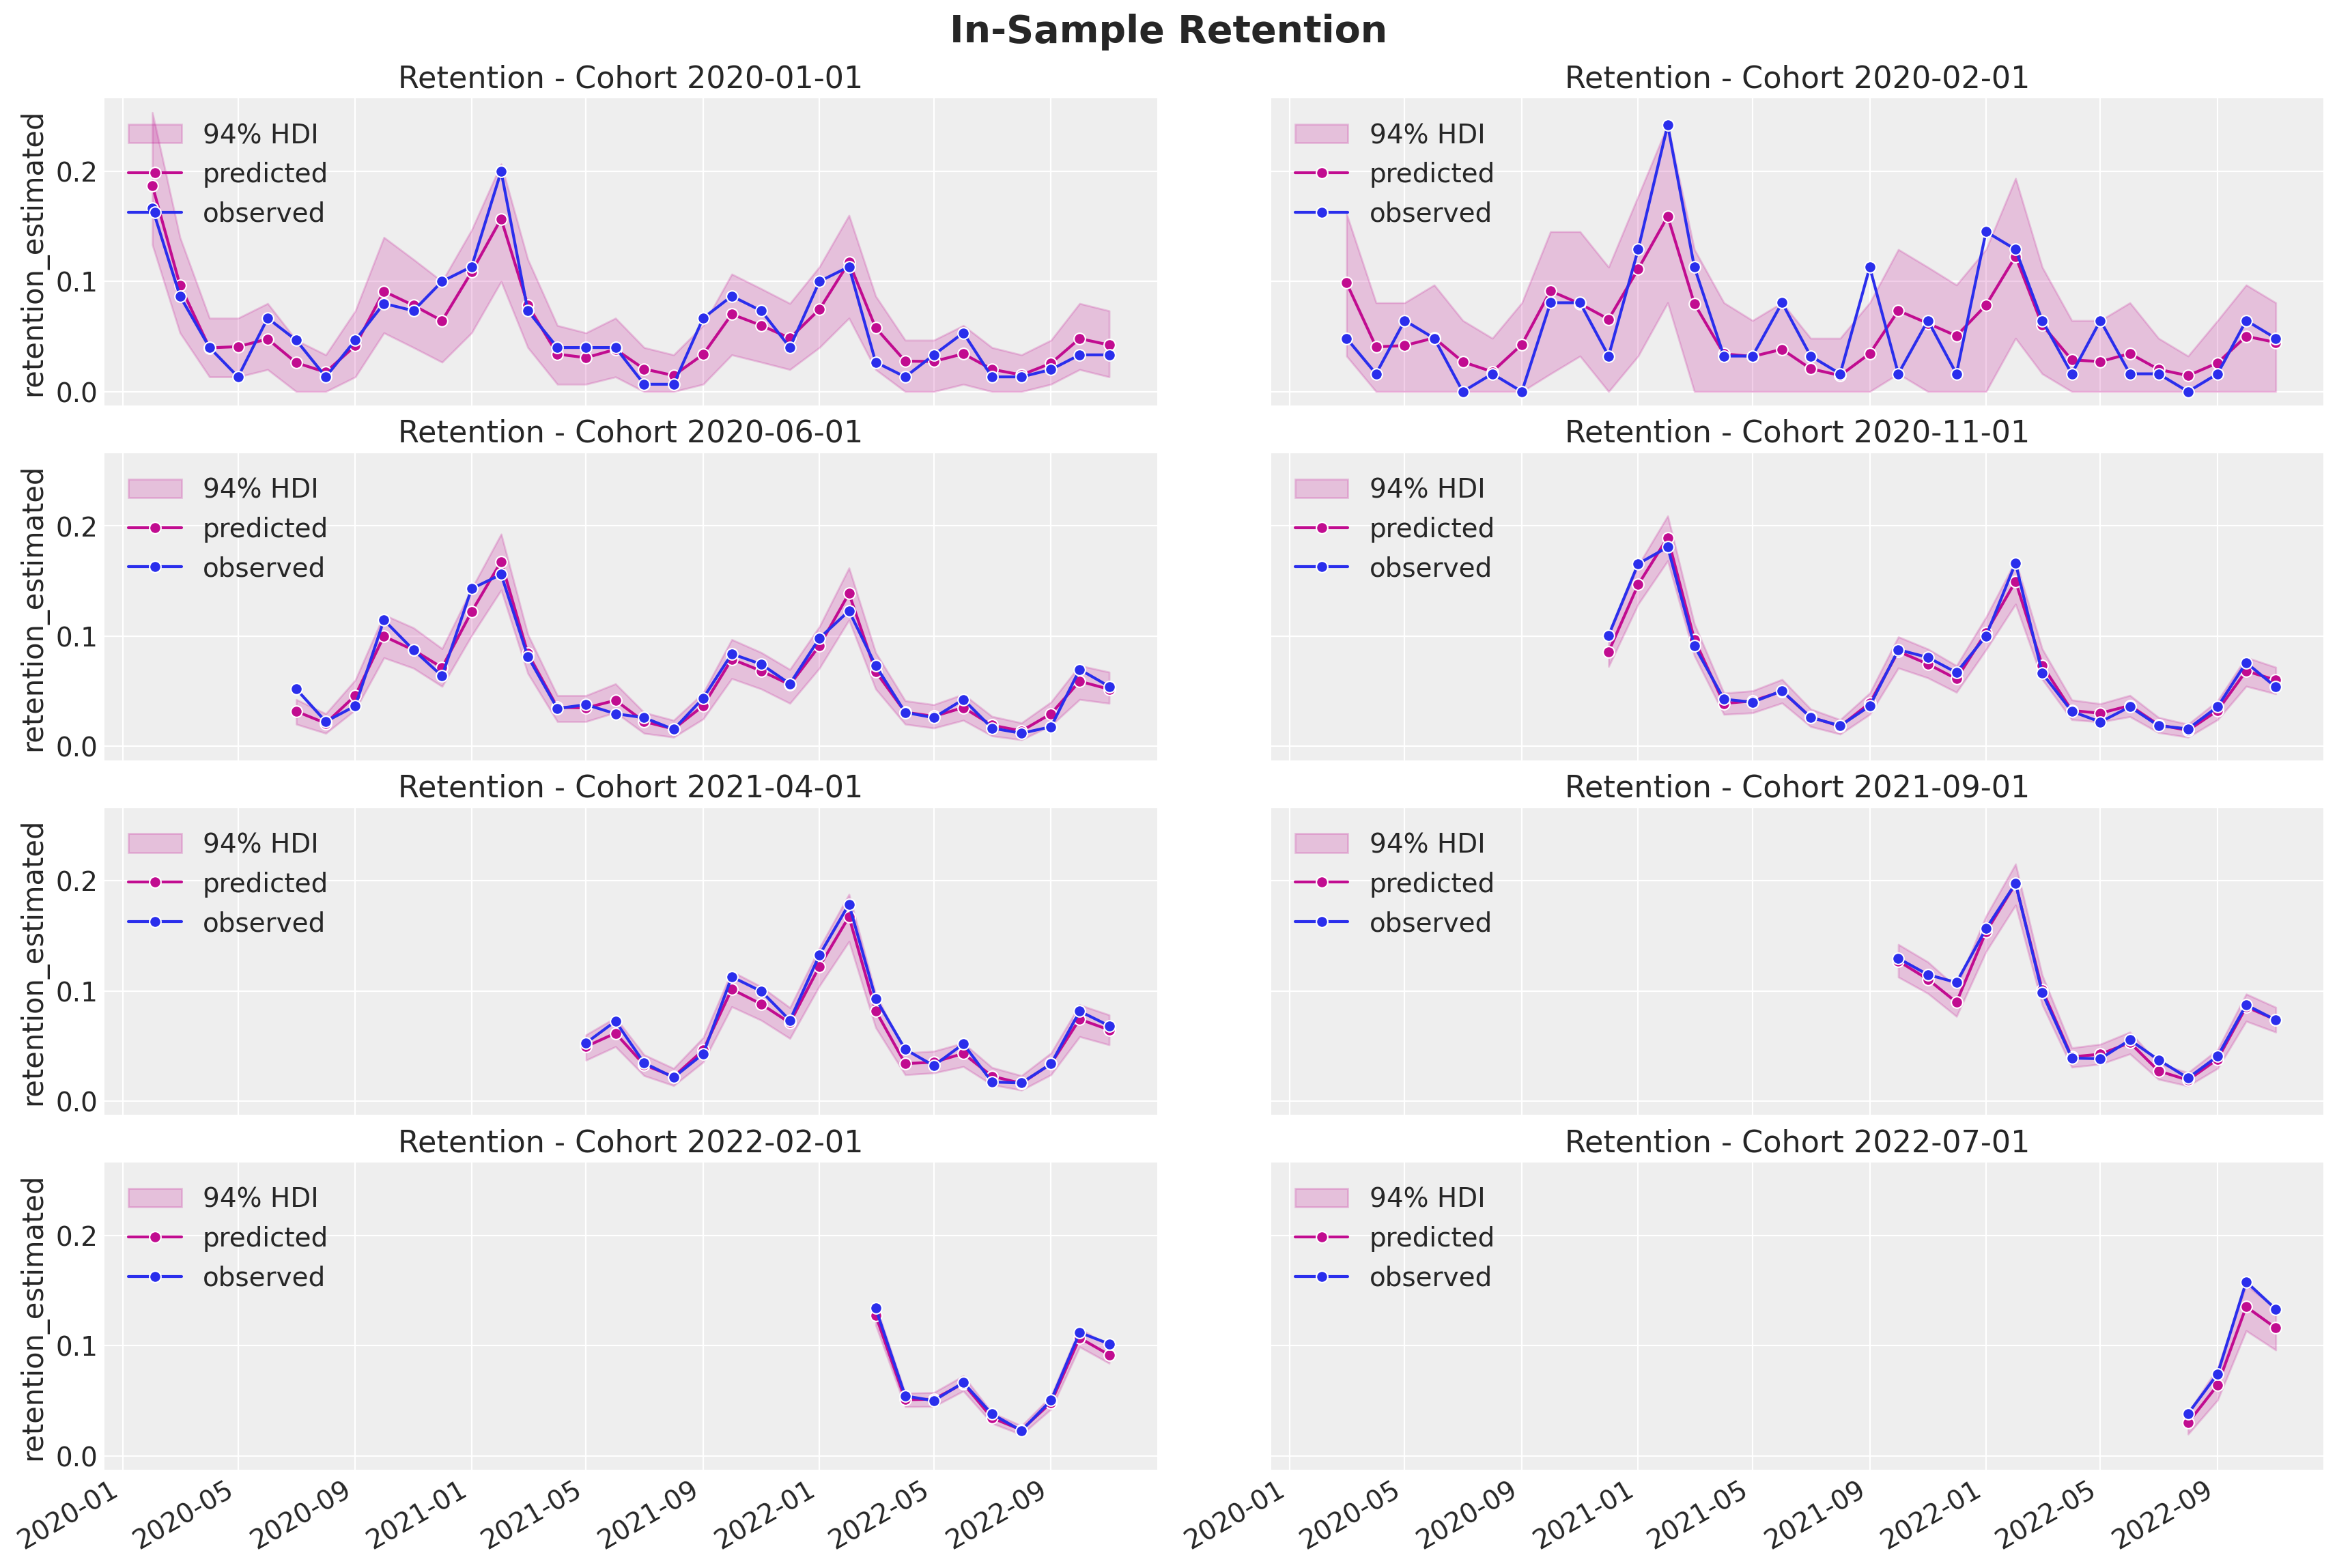

In [19]:
train_retention_hdi = az.hdi(ary=idata_svi["posterior_predictive"])[
    "retention_estimated"
]


def plot_train_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = train_cohort_idx == cohort_index

    ax.fill_between(
        x=train_period[train_period_idx[mask]],
        y1=train_retention_hdi[mask, :][:, 0],
        y2=train_retention_hdi[mask, :][:, 1],
        alpha=0.2,
        color="C3",
        label="94% HDI",
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=idata_svi["posterior_predictive"]["retention_estimated"].mean(
            dim=["chain", "draw"]
        )[mask],
        marker="o",
        color="C3",
        label="predicted",
        ax=ax,
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_retention[mask],
        color="C0",
        marker="o",
        label="observed",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Retention - Cohort {cohort_name}")
    return ax


cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(17, 11),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)

fig.suptitle("In-Sample Retention", y=1.03, fontsize=20, fontweight="bold")
fig.autofmt_xdate()

- Revenue

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_51400/665120427.py:58: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


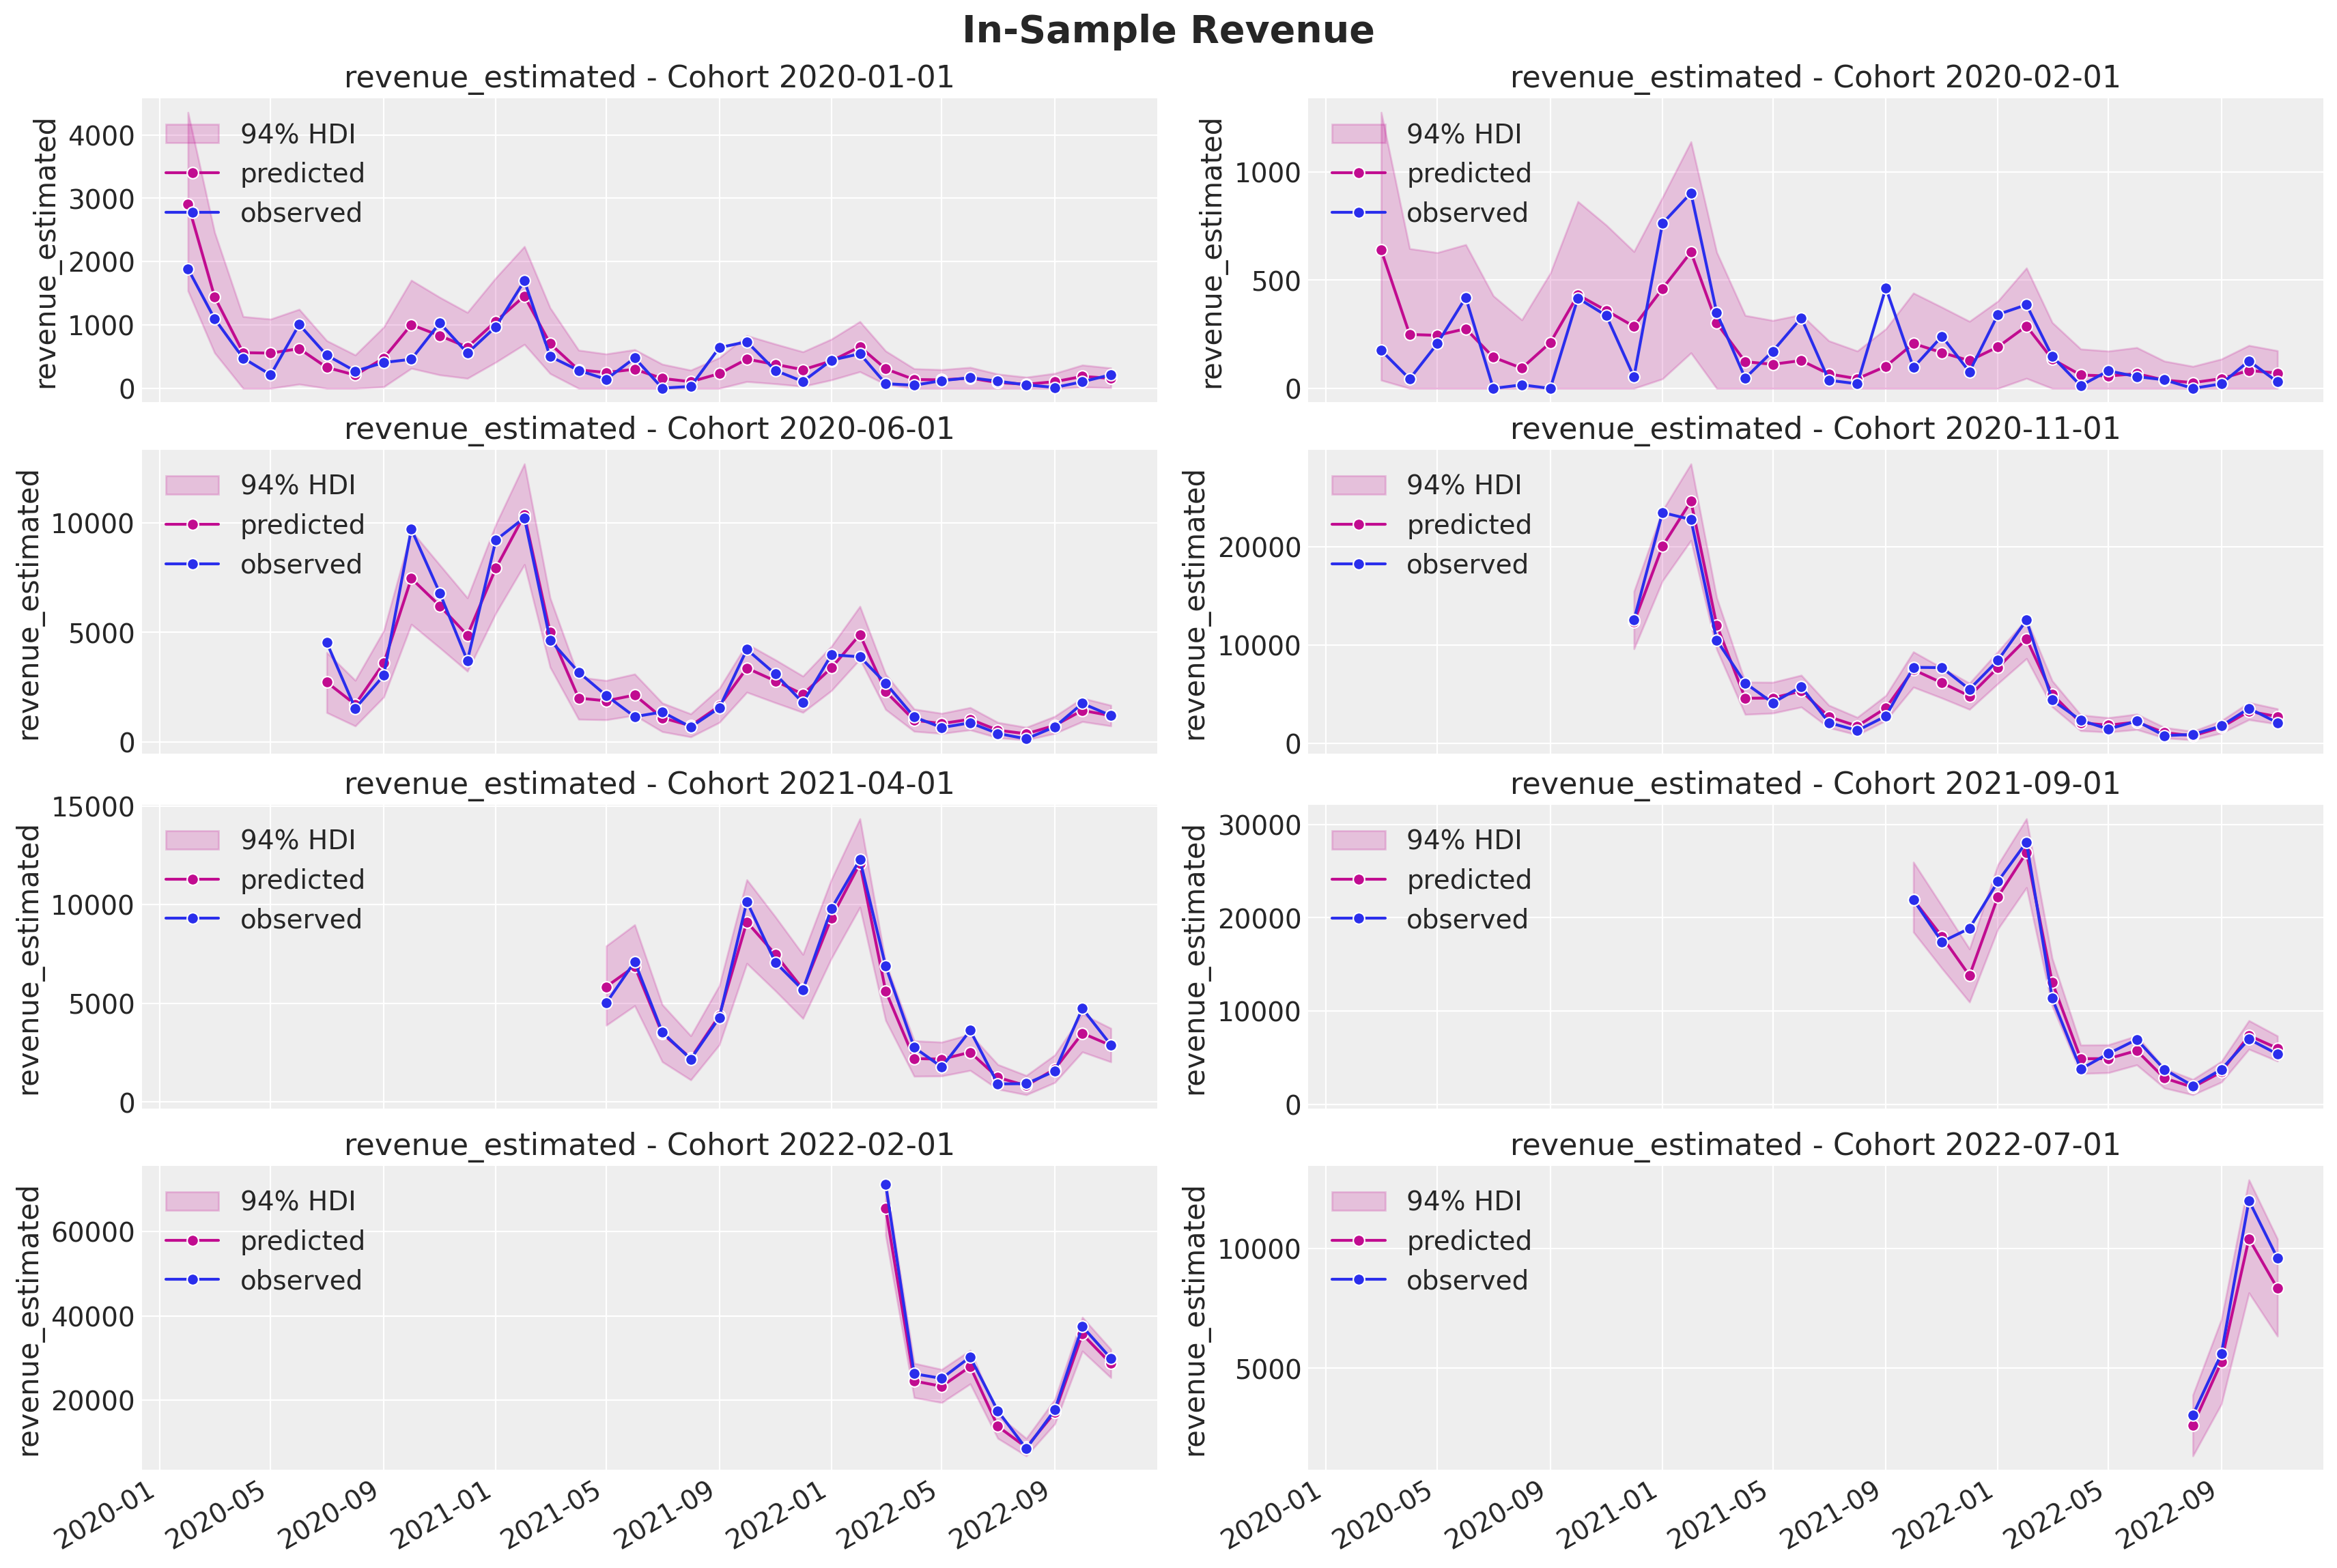

In [20]:
train_revenue_estimated_hdi = az.hdi(ary=idata_svi["posterior_predictive"])[
    "revenue_estimated"
]


def plot_train_revenue_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = train_cohort_idx == cohort_index

    ax.fill_between(
        x=train_period[train_period_idx[mask]],
        y1=train_revenue_estimated_hdi[mask, :][:, 0],
        y2=train_revenue_estimated_hdi[mask, :][:, 1],
        alpha=0.2,
        color="C3",
        label="94% HDI",
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=idata_svi["posterior_predictive"]["revenue_estimated"].mean(
            dim=["chain", "draw"]
        )[mask],
        marker="o",
        color="C3",
        label="predicted",
        ax=ax,
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_revenue[mask],
        color="C0",
        marker="o",
        label="observed",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.legend(loc="upper left")
    ax.set(title=f"revenue_estimated - Cohort {cohort_name}")
    return ax


cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(17, 11),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_revenue_hdi_cohort(cohort_index=cohort_index, ax=ax)

fig.suptitle("In-Sample Revenue", y=1.03, fontsize=20, fontweight="bold")
fig.autofmt_xdate()

The fit look very good and are very similar to the ones obtained with the BART model! Note that the HDI intervals are wider for smaller cohorts as expected.

## Out-of-Sample Predictions

Now we prepare the data for the out-of-sample predictions.

In [21]:
test_data_red_df = test_data_df.query("cohort_age > 0")
test_data_red_df = test_data_red_df[
    test_data_red_df["cohort"].isin(train_data_red_df["cohort"].unique())
].reset_index(drop=True)
test_obs_idx = test_data_red_df.index.to_numpy()
test_n_users = test_data_red_df["n_users"].to_numpy()
test_n_active_users = test_data_red_df["n_active_users"].to_numpy()
test_retention = test_data_red_df["retention"].to_numpy()
test_revenue = test_data_red_df["revenue"].to_numpy()

test_cohort = test_data_red_df["cohort"].to_numpy()
test_cohort_idx = train_cohort_encoder.transform(test_cohort).flatten()

test_data_red_df["month"] = test_data_red_df["period"].dt.strftime("%m").astype(int)
test_data_red_df["cohort_month"] = (
    test_data_red_df["cohort"].dt.strftime("%m").astype(int)
)
test_data_red_df["period_month"] = (
    test_data_red_df["period"].dt.strftime("%m").astype(int)
)
x_test = test_data_red_df[features]

test_age = test_data_red_df["age"].to_numpy()
test_age_scaled = train_age_scaler.transform(test_age.reshape(-1, 1)).flatten()
test_cohort_age = test_data_red_df["cohort_age"].to_numpy()
test_cohort_age_scaled = train_cohort_age_scaler.transform(
    test_cohort_age.reshape(-1, 1)
).flatten()

In [22]:
test_n_users = jnp.array(test_n_users)
test_n_active_users = jnp.array(test_n_active_users)
test_revenue = jnp.array(test_revenue)

x_test_preprocessed = preprocessor.transform(x_test)
x_test_preprocessed_array = jnp.array(x_test_preprocessed)

Now we are ready to sample from the posterior distribution.

In [23]:
test_predictive = Predictive(
    model=model, guide=guide, params=params, num_samples=4 * 2_000
)
rng_key, rng_subkey = random.split(key=rng_key)
test_posterior_predictive_samples = test_predictive(
    rng_subkey,
    x_test_preprocessed_array,
    test_age_scaled,
    test_cohort_age_scaled,
    test_n_users,
)

Again, we structure the samples as an  [`az.InferenceData`](https://python.arviz.org/en/stable/api/generated/arviz.InferenceData.html) object.

In [24]:
test_idata_svi = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in test_posterior_predictive_samples.items()
    },
    coords={"obs_idx": test_obs_idx},
    dims={
        "retention": ["obs_idx"],
        "n_active_users_estimates": ["obs_idx"],
        "revenue_estimated": ["obs_idx"],
    },
)

Let's now look at the actual against the predictions.

- Retention

Text(0.5, 1.0, 'True vs Predicted Retention (test)')

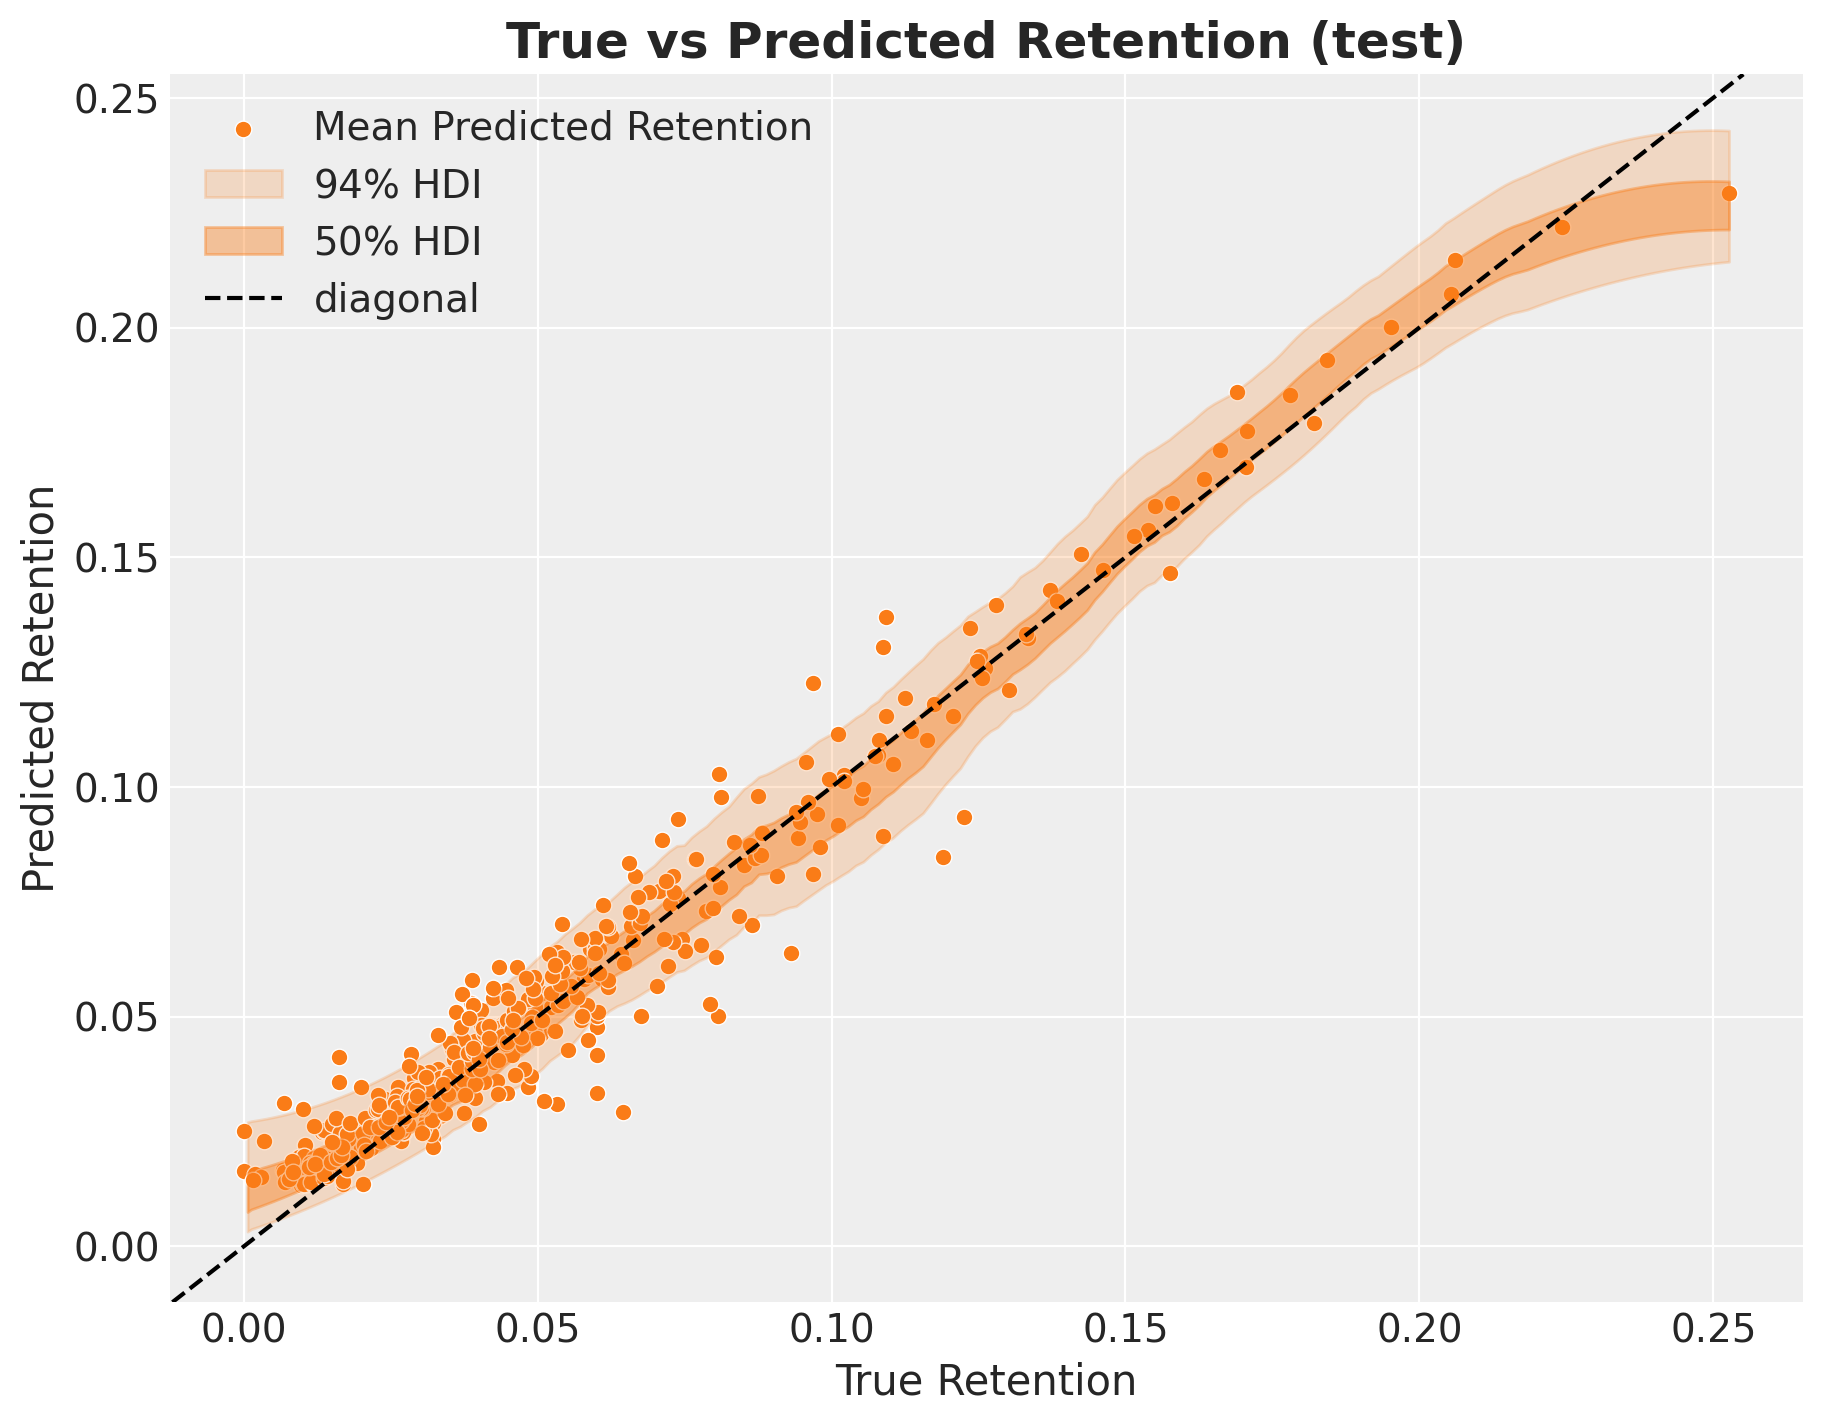

In [25]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(
    x=test_retention,
    y=test_idata_svi["posterior_predictive"]["retention_estimated"].mean(
        dim=["chain", "draw"]
    ),
    color="C1",
    label="Mean Predicted Retention",
    ax=ax,
)
az.plot_hdi(
    x=test_retention,
    y=test_idata_svi["posterior_predictive"]["retention_estimated"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=test_retention,
    y=test_idata_svi["posterior_predictive"]["retention_estimated"],
    hdi_prob=0.5,
    color="C1",
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI"},
    ax=ax,
)
ax.axline((0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend(loc="upper left")
ax.set(xlabel="True Retention", ylabel="Predicted Retention")
ax.set_title(label="True vs Predicted Retention (test)", fontsize=18, fontweight="bold")

- Revenue

Text(0.5, 1.0, 'True vs Predicted Revenue (test)')

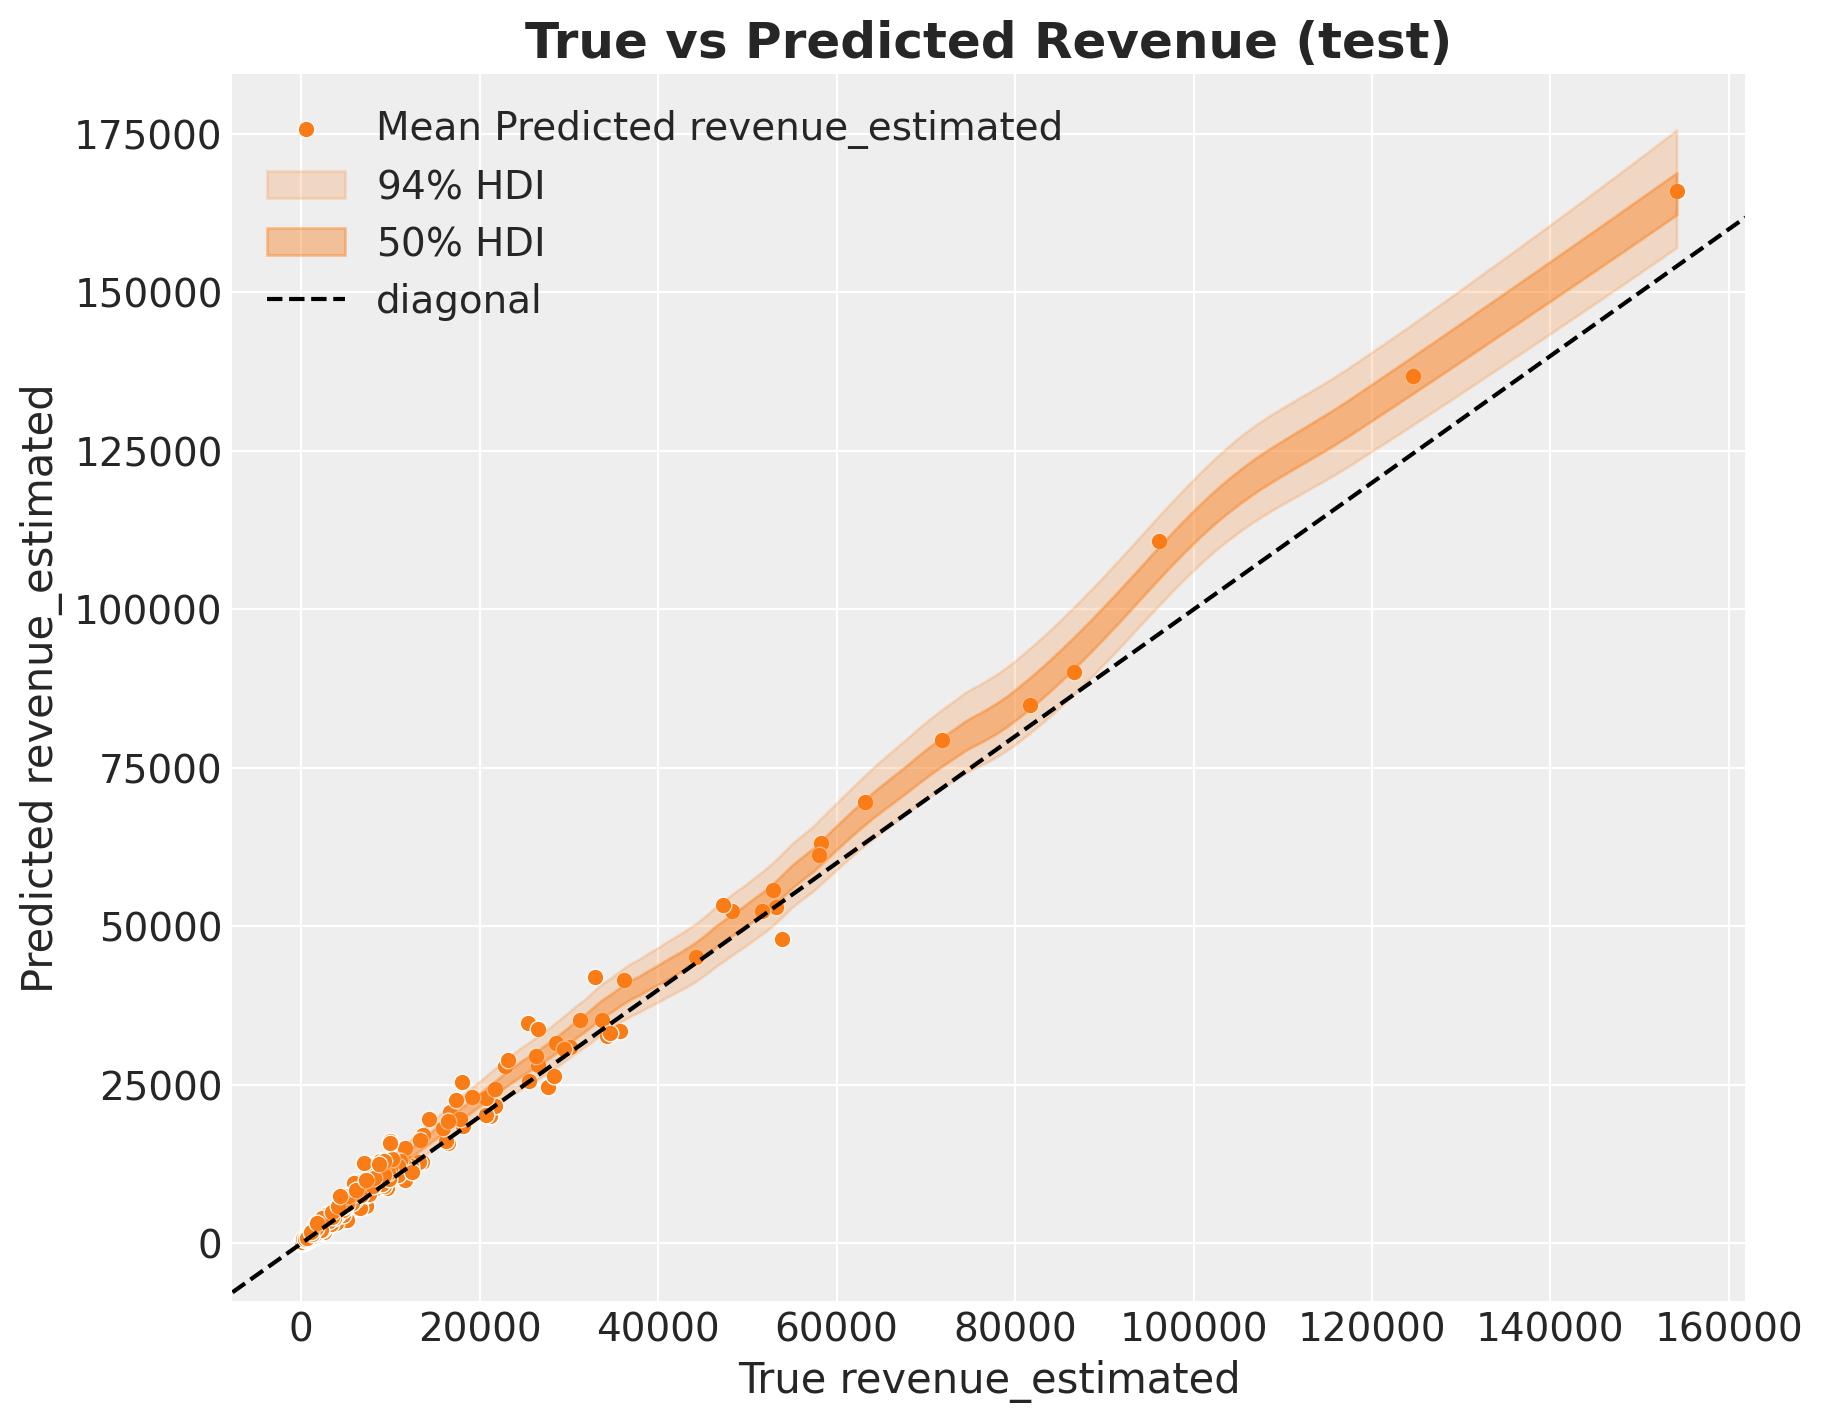

In [26]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(
    x=test_revenue,
    y=test_idata_svi["posterior_predictive"]["revenue_estimated"].mean(
        dim=["chain", "draw"]
    ),
    color="C1",
    label="Mean Predicted revenue_estimated",
    ax=ax,
)
az.plot_hdi(
    x=test_revenue,
    y=test_idata_svi["posterior_predictive"]["revenue_estimated"],
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=test_revenue,
    y=test_idata_svi["posterior_predictive"]["revenue_estimated"],
    hdi_prob=0.5,
    color="C1",
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI"},
    ax=ax,
)
ax.axline((0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend(loc="upper left")
ax.set(xlabel="True revenue_estimated", ylabel="Predicted revenue_estimated")
ax.set_title(label="True vs Predicted Revenue (test)", fontsize=18, fontweight="bold")

The retention predictions look very good whereas the revenue ones seem a bit higher for cohorts with higher revenue. This is also similar to the BART model.

Finally, lets get out of sample predictions for the selected subset of cohorts.

- Retention

In [27]:
test_retention_hdi = az.hdi(ary=test_idata_svi["posterior_predictive"])[
    "retention_estimated"
]


def plot_test_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.query(
        f"cohort == '{train_cohort_encoder.classes_[cohort_index]}'"
    )["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_retention_hdi[mask, :][:, 0],
        y2=test_retention_hdi[mask, :][:, 1],
        alpha=0.2,
        color="C3",
    )

    sns.lineplot(
        x=test_period_range,
        y=test_idata_svi["posterior_predictive"]["retention_estimated"].mean(
            dim=["chain", "draw"]
        )[mask],
        marker="o",
        color="C3",
        ax=ax,
    )
    sns.lineplot(
        x=test_period_range,
        y=test_retention[mask],
        color="C1",
        marker="o",
        label="observed (test)",
        ax=ax,
    )
    return ax

Text(0.5, 1.03, 'Retention Predictions')

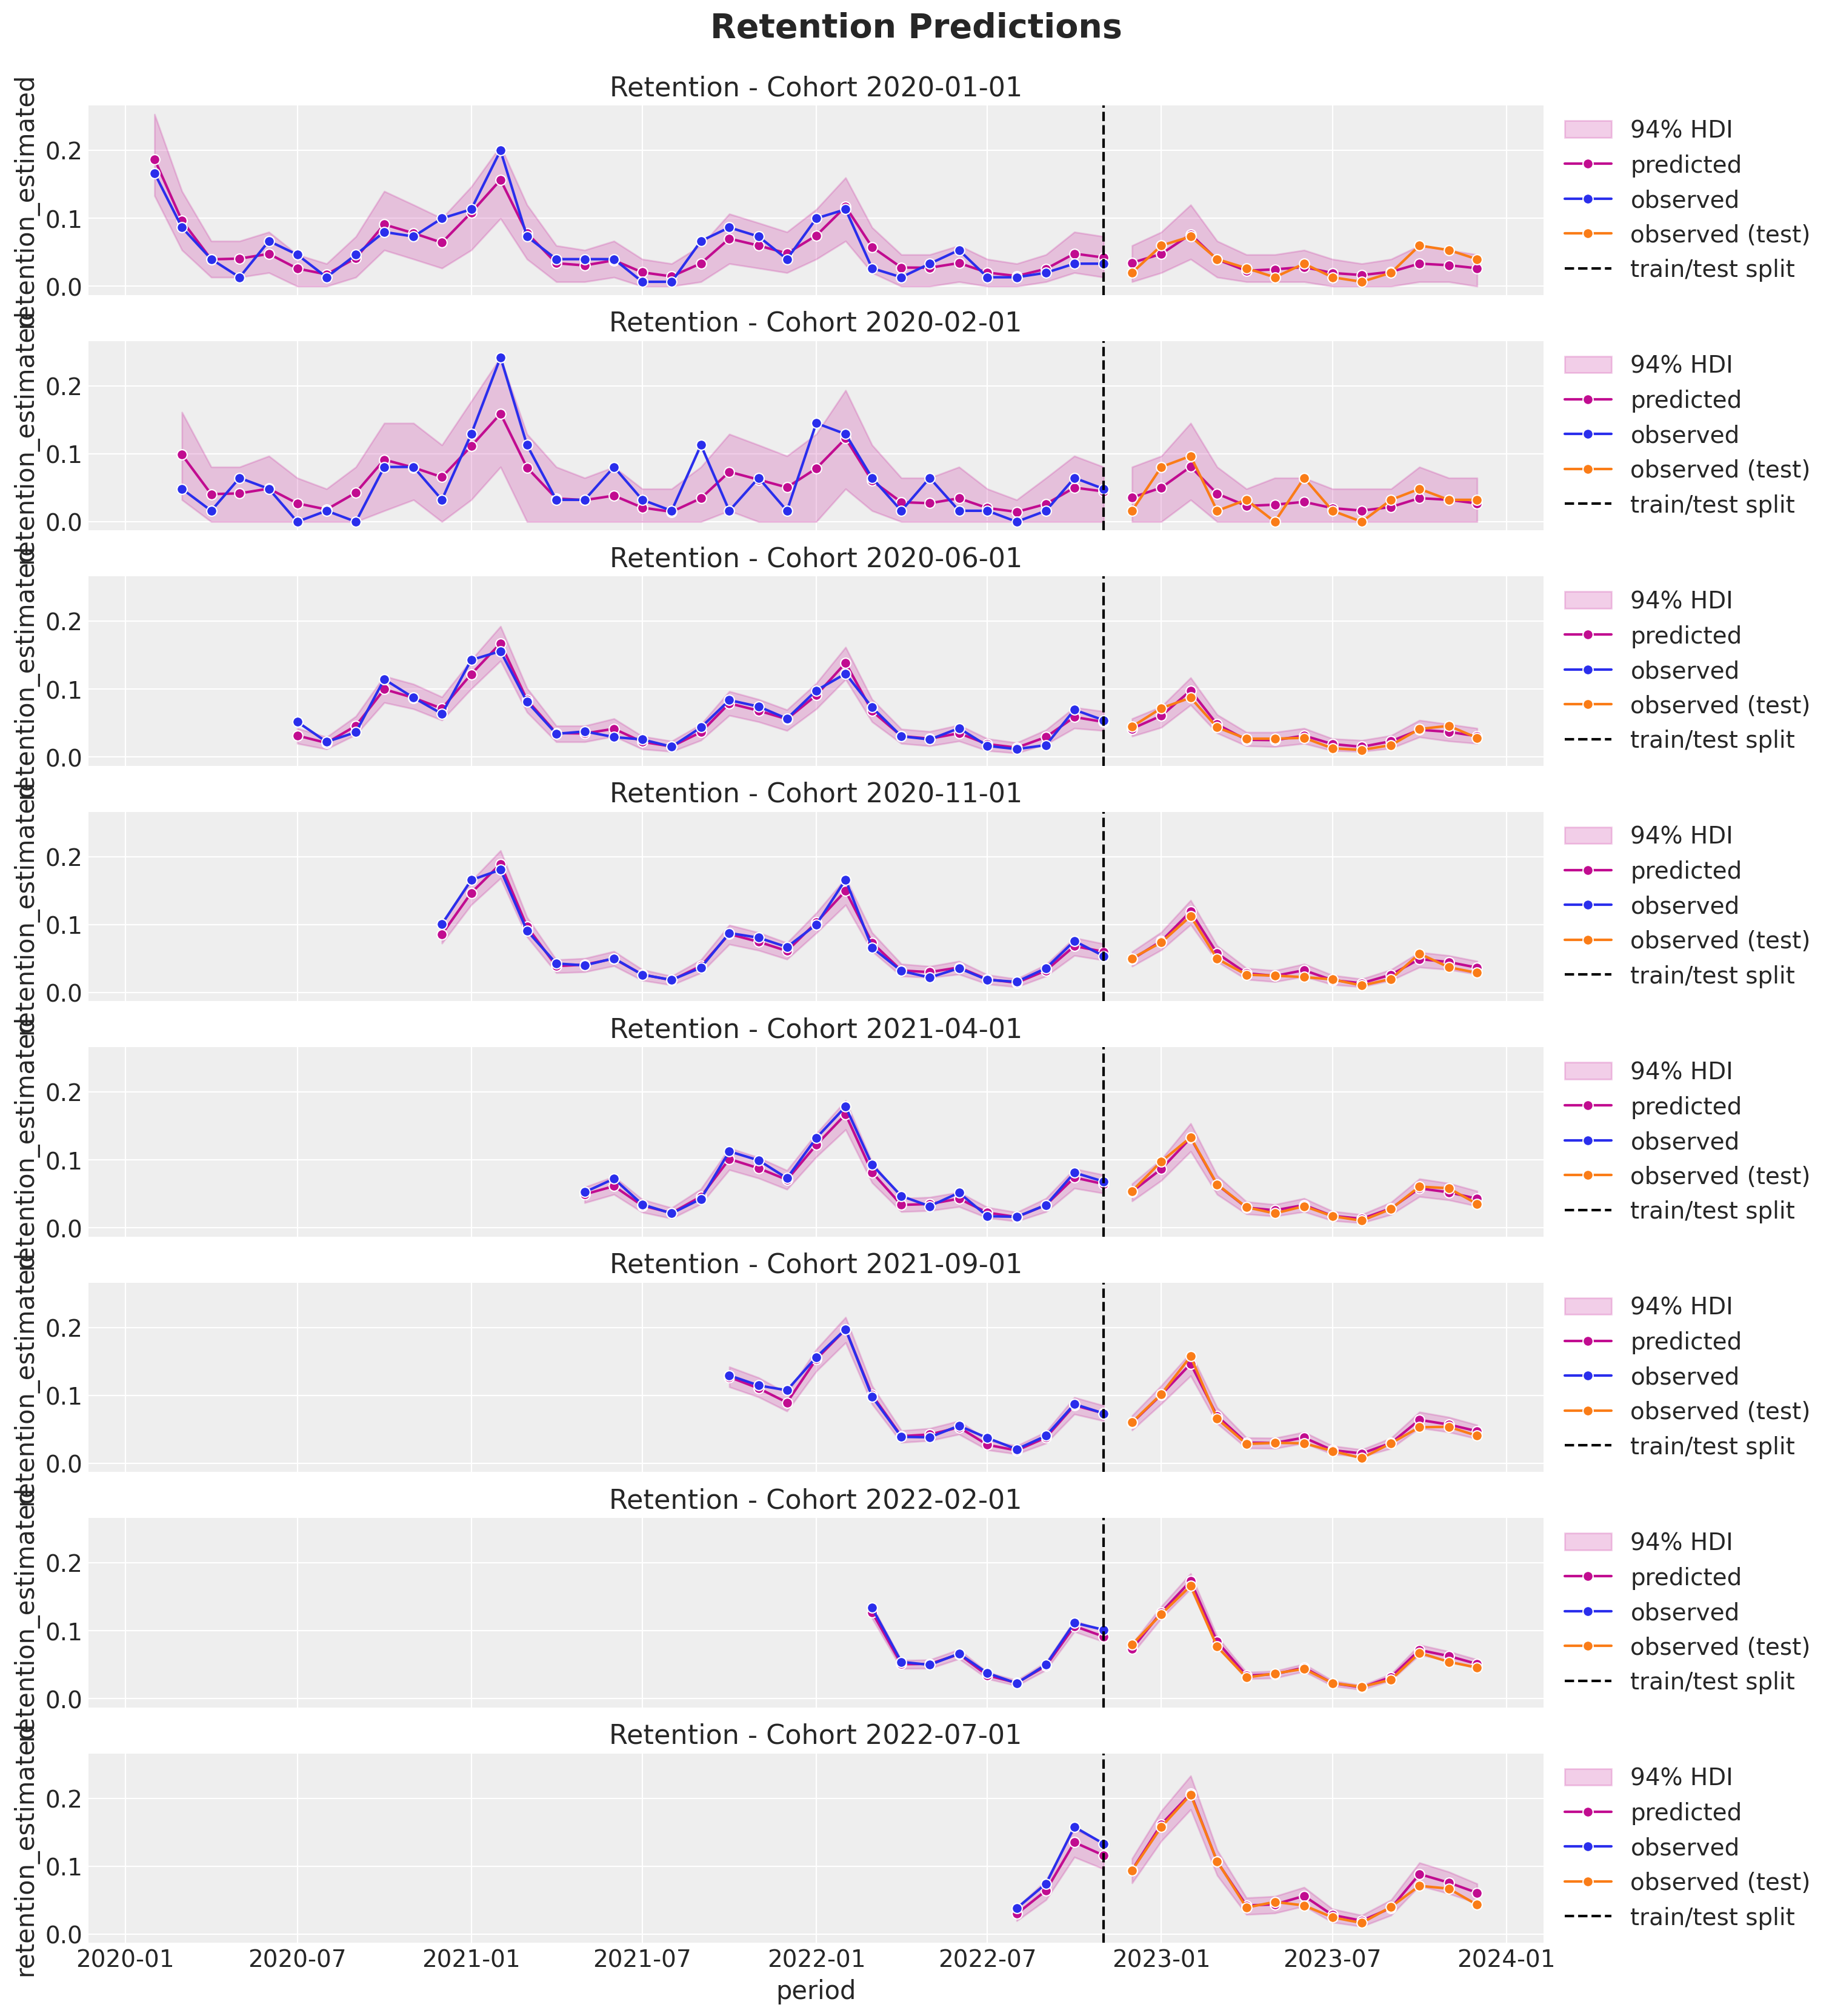

In [28]:
cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(15, 16),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/test split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.suptitle("Retention Predictions", y=1.03, fontsize=20, fontweight="bold")

- Revenue

In [29]:
test_revenue_estimated_hdi = az.hdi(ary=test_idata_svi["posterior_predictive"])[
    "revenue_estimated"
]


def plot_test_revenue_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.query(
        f"cohort == '{train_cohort_encoder.classes_[cohort_index]}'"
    )["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_revenue_estimated_hdi[mask, :][:, 0],
        y2=test_revenue_estimated_hdi[mask, :][:, 1],
        alpha=0.2,
        color="C3",
    )

    sns.lineplot(
        x=test_period_range,
        y=test_idata_svi["posterior_predictive"]["revenue_estimated"].mean(
            dim=["chain", "draw"]
        )[mask],
        marker="o",
        color="C3",
        ax=ax,
    )
    sns.lineplot(
        x=test_period_range,
        y=test_revenue[mask],
        color="C1",
        marker="o",
        label="observed (test)",
        ax=ax,
    )
    return ax

Text(0.5, 1.03, 'Revenue Predictions')

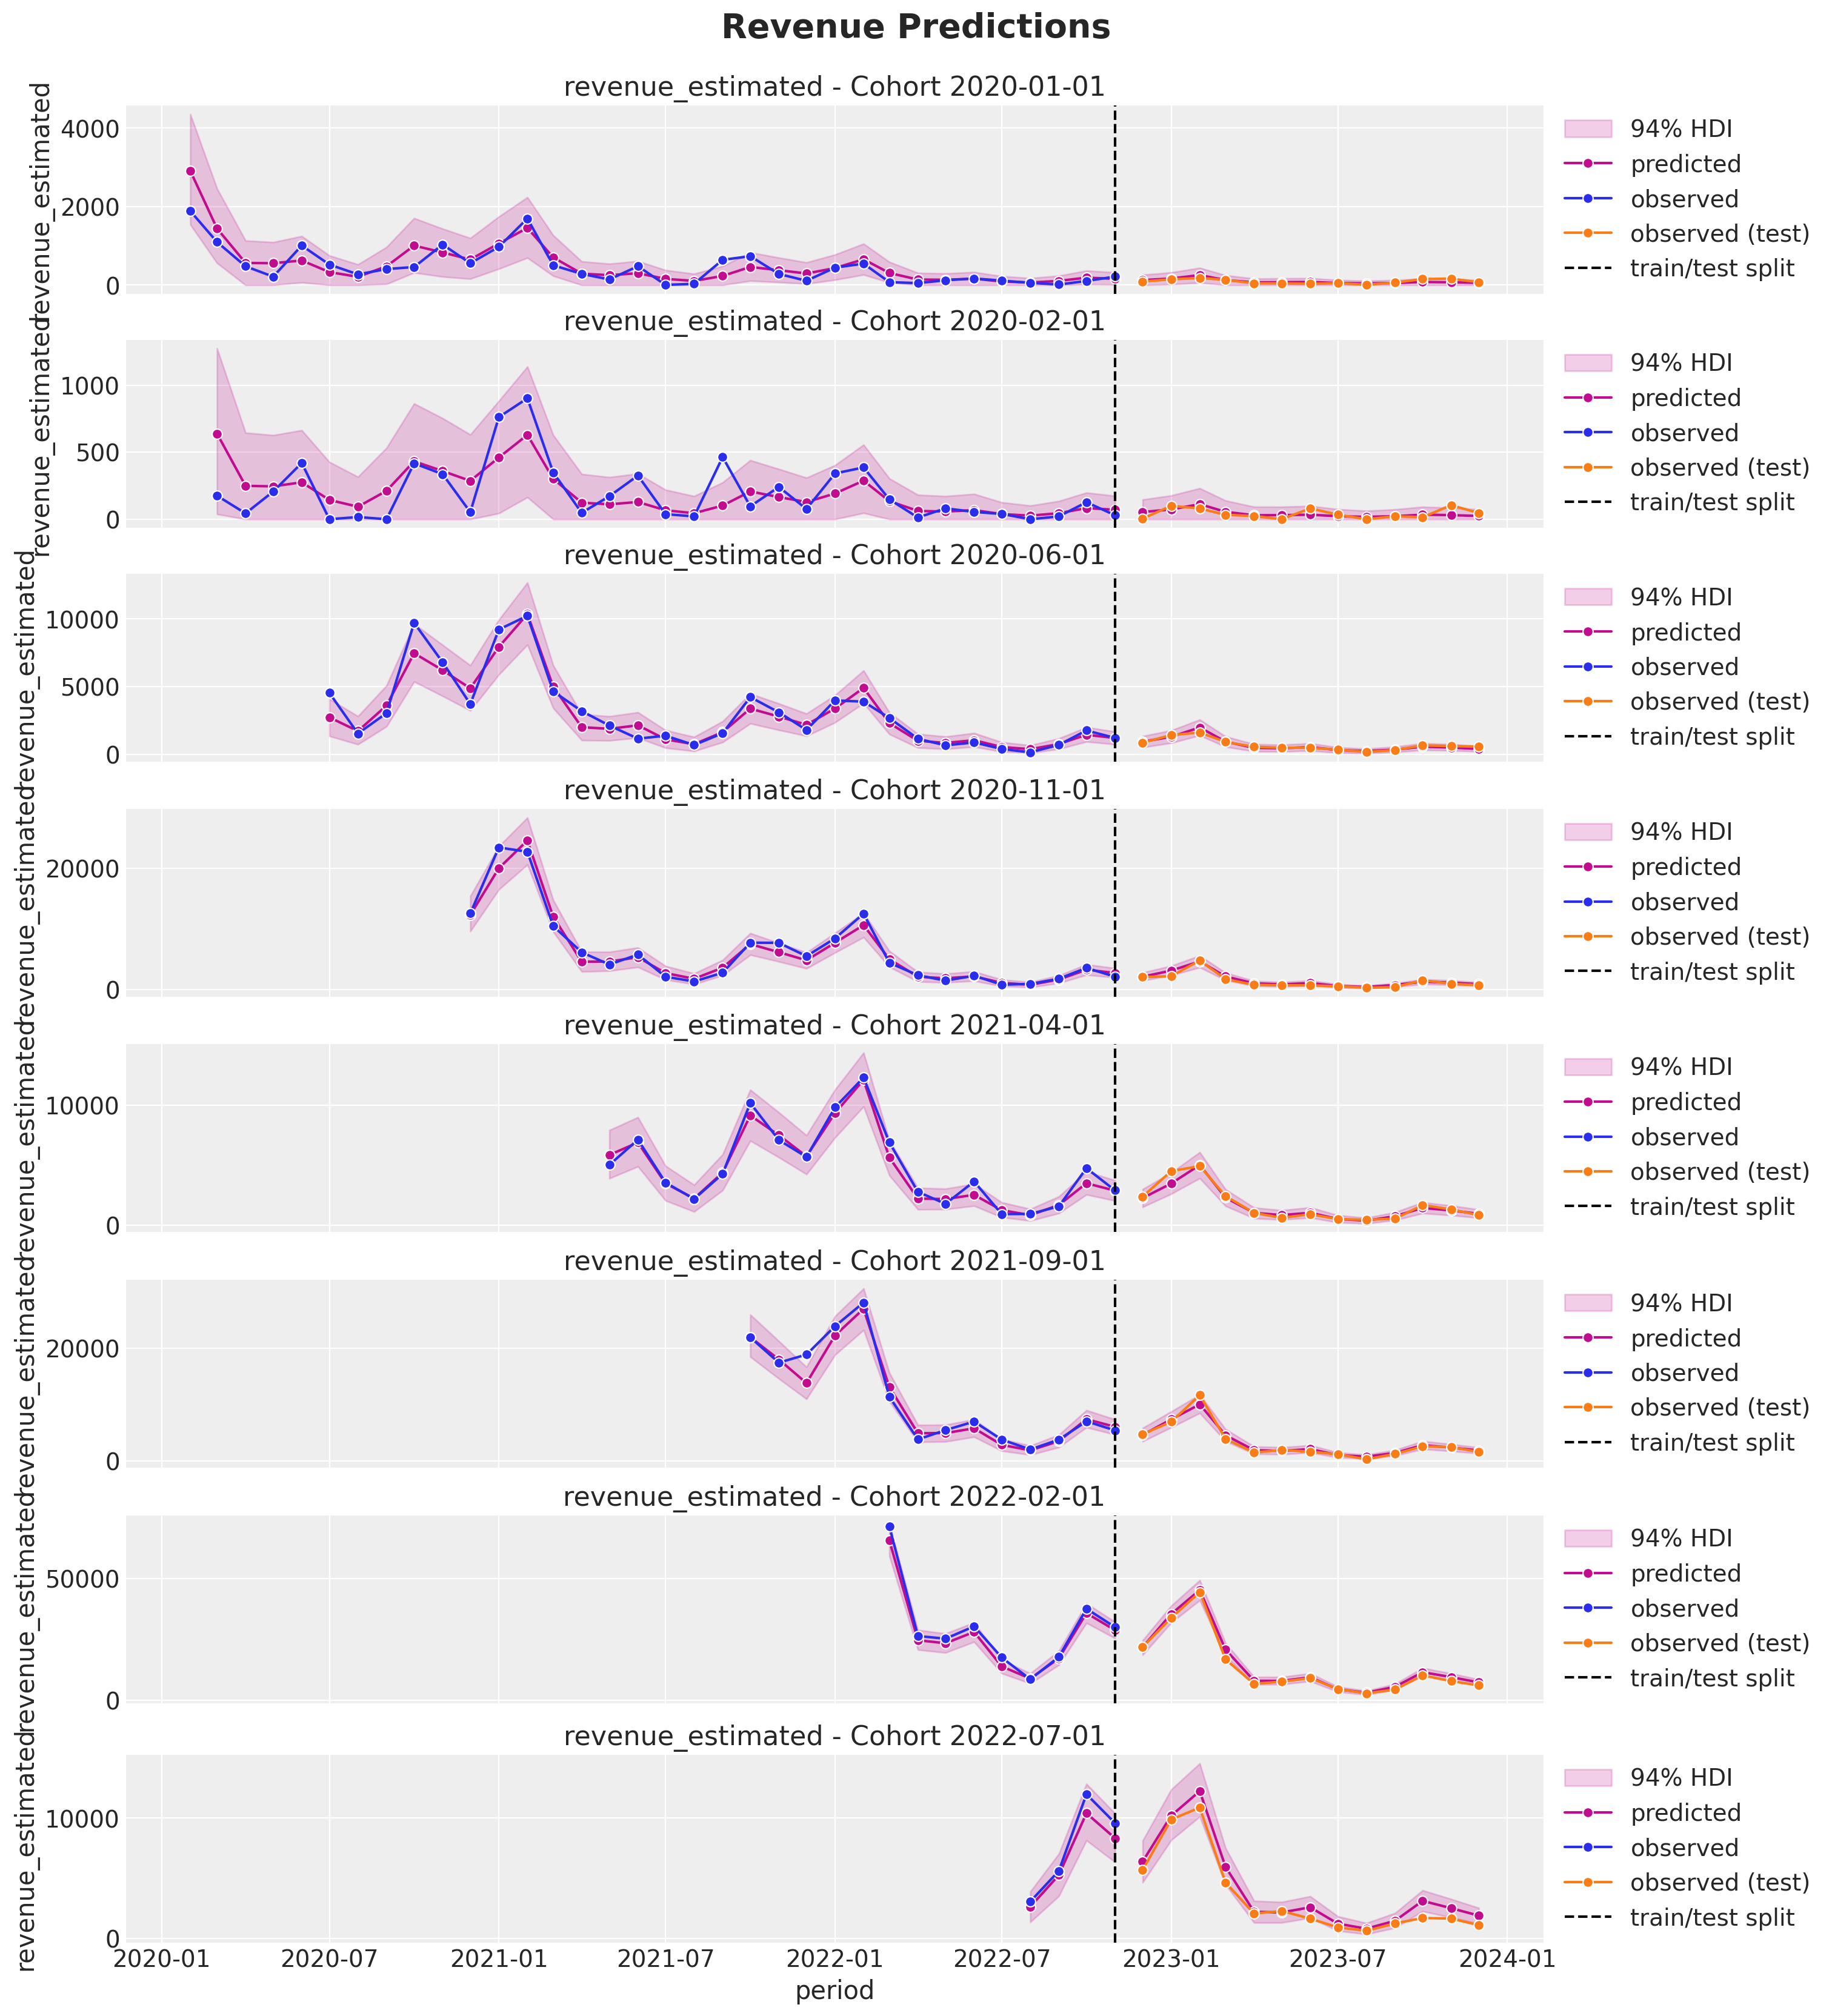

In [30]:
cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(15, 16),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_revenue_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_revenue_hdi_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/test split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.suptitle("Revenue Predictions", y=1.03, fontsize=20, fontweight="bold")

The results look very good! Both the posterior mean and the uncertainty as a function of the cohort size.

This extension of the model allow us for greater flexibility without compromising the inference speed (it is actually much faster) or accuracy. We could actually iterate on the model development with SVI and then get posterior samples via full HMC (NUTS). This is also fast for the typical dataset sizes we have in this type of problems.